## 3D_cellpose Prediction (Last Update 2022-08-02)

In [1]:
import numpy as np
import time, os, sys
import skimage.io
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

#import mxnet as mx
from cellpose import utils
from cellpose import io
from cellpose import models
from cellpose import plot

from glob import glob
from tifffile import imread
from tifffile import imsave
from tifffile import imwrite

In [2]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$ User Settings $$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# 1. Input path 
imgs = sorted(glob('D:/Data/External/NaemiKuehn/2022-04-07/3DROIsforCellPose/O/*.tif'))
file_name = os.listdir('D:/Data/External/NaemiKuehn/2022-04-07/3DROIsforCellPose/O/') # User setting

# 2. Select GPU (default = 0)
# Recommended if you want to use a specific GPU (e.g. mx.gpu(4))
selected_GPU = 0 # User input
torch = False

# 3. Model type:
#    a. model_type='cyto'
#    b. model_type='nuclei'
model_type = 'nuclei'

# 4. Define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
#     a. channels = [0,0] # IF YOU HAVE GRAYSCALE
#     b. channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
#     c. channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
channels = [0,0]

# Not recomended: To segment one grayscale image and one image with cells in green and nuclei in blue, input [[0,0], [2,3]]
# or if you have different types of channels in each image
# channels = [[0,0],[2,3], ...]

# 5. Specify cell diameter in pixels and the anisotropy in z 
# Naemi settings: 15, 2.0, 8, torch=False
diameter = 15 #30 #12
anisotropy = 2.0 #2.0
batch_size = 8# default = 8 reduce the batch_size if you get GPU OOM errors

# 6. Display the images while running the notebook
display_intermendiated_results = True

# 7. Default is 16 bits but in case of a large stack use 32 bits label images
large_objs_number = False

In [3]:
# This function can be customized further
def print_user_setting(imgs, file_name, model_type, channels, diameter, anisotropy, batch_size):    
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    print('$$$$$$$$$$$$$$$$$$$$$$$ User Settings $$$$$$$$$$$$$$$$$$$$$$$$')
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')
    for l in range (len(imgs)):
        print('>>>', (l+1), 'Input images:', file_name[l])   
    print('\n>>> Model type:', model_type)
    print('>>> Channel to segment:', channels)
    print('>>> Cell diameter:', diameter)
    print('>>> Anisotropy:', diameter)
    print('>>> Batch size:', batch_size)

In [4]:
# Check CUDA installation and specify the GPU to use [0,1,...]
!nvcc -V
use_GPU = models.use_gpu(selected_GPU)
print('Selected GPU %d'%use_GPU)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:04_Central_Daylight_Time_2018
Cuda compilation tools, release 10.0, V10.0.130
Selected GPU 1


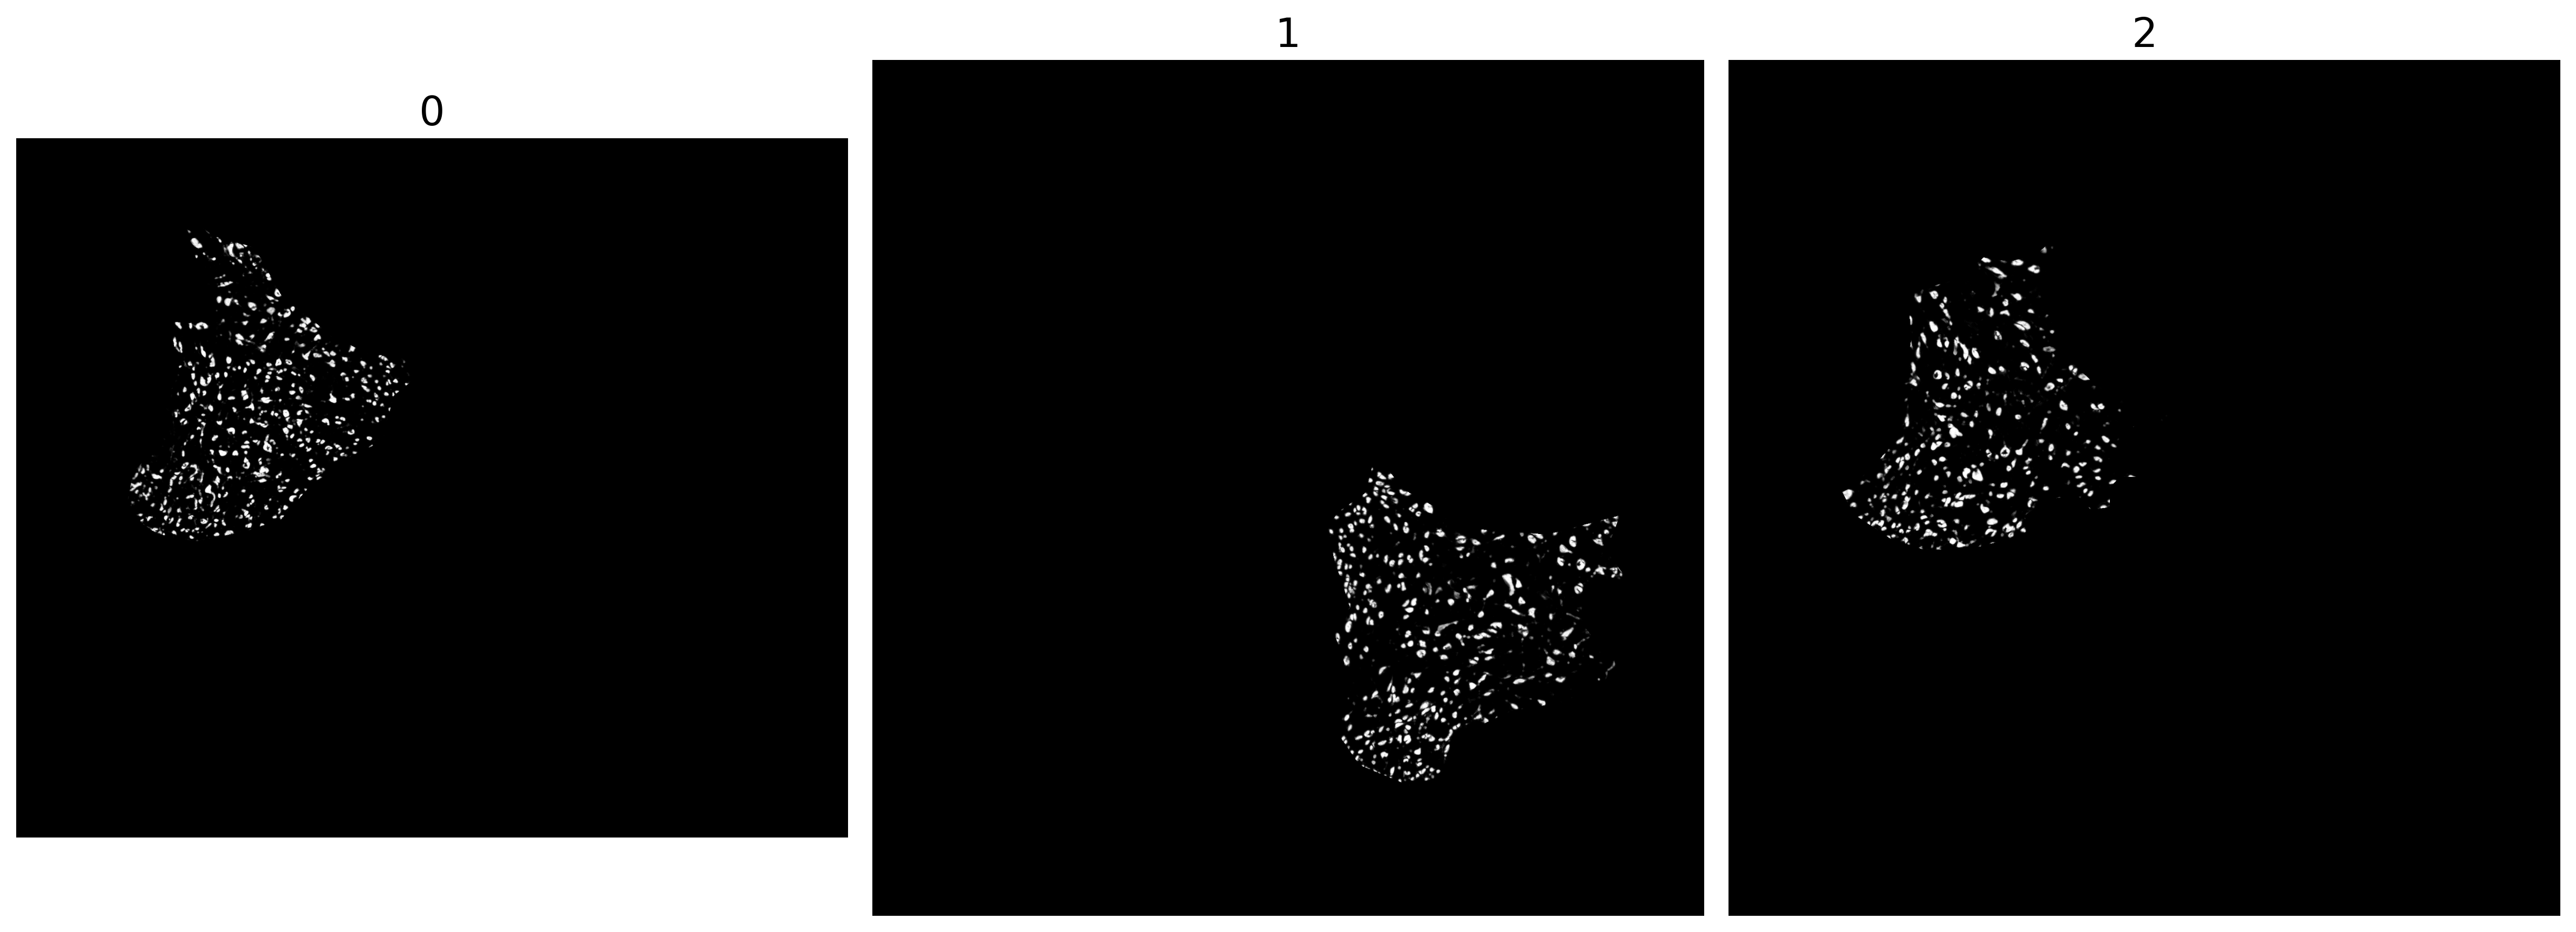

In [5]:
# Input directroy path
imgs = imgs
results_dir = os.path.dirname(imgs[0])
file_name = file_name
imgs = list(map(imread,imgs))

if display_intermendiated_results == True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, imgs)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i,fontsize=18)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()

## Run cellpose model on input images

In [6]:
# Import Cellpose model
model = models.Cellpose(gpu=use_GPU, model_type=model_type, torch=torch) 

# Apply the pretrained model (default 0.4)
print(file_name)
masks, flows, styles, diams = model.eval(imgs, diameter=diameter, flow_threshold=0.8, cellprob_threshold=0.2, batch_size=batch_size, channels=channels, tile=True, do_3D=True, anisotropy=anisotropy, augment=True)

['061_Stitched_C3-21-03_2 weeks_Animal 8_Slide 7L_Slice 6_DAPI_Iba1_NeuN_2_PM Right.tif', '062_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5I_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif', '062_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5I_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif', '063_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5K_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif', '063_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5K_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif', '064_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5M_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif', '064_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5M_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif', '065_Stitched_C3-21-03_2 weeks_Animal 10_Slide 5H_Slice 6_DAPI_Iba1_NeuN_2_PM Left.tif', '065_Stitched_C3-21-03_2 weeks_Animal 10_Slide 5H_Slice 6_DAPI_Iba1_NeuN_2_PM Right.tif', '066_Stitched_C3-21-03_2 weeks_Animal 10_Slide 5J_Slice 7_DAPI_Iba1_NeuN_2_PM Left.tif', '066_Stitched_C3-21-03_2 weeks_Animal 10_Slide 5J_Slice 7_DAPI_Iba1_NeuN_2_PM Right.tif']
Max X  65535.0
Min X 

In [7]:
# Output user settings (After the settings are applied)
print_user_setting(imgs, file_name, model_type, channels, diameter, anisotropy, batch_size)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$ User Settings $$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

>>> 1 Input images: 061_Stitched_C3-21-03_2 weeks_Animal 8_Slide 7L_Slice 6_DAPI_Iba1_NeuN_2_PM Right.tif
>>> 2 Input images: 062_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5I_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif
>>> 3 Input images: 062_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5I_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif
>>> 4 Input images: 063_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5K_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif
>>> 5 Input images: 063_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5K_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif
>>> 6 Input images: 064_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5M_Slice 5_DAPI_Iba1_NeuN_2_PM Left.tif
>>> 7 Input images: 064_Stitched_C3-21-03_2 weeks_Animal 9_Slide 5M_Slice 5_DAPI_Iba1_NeuN_2_PM Right.tif
>>> 8 Input images: 065_Stitched_C3-21-03_2 weeks_Animal 10_Slide 5H_Sl

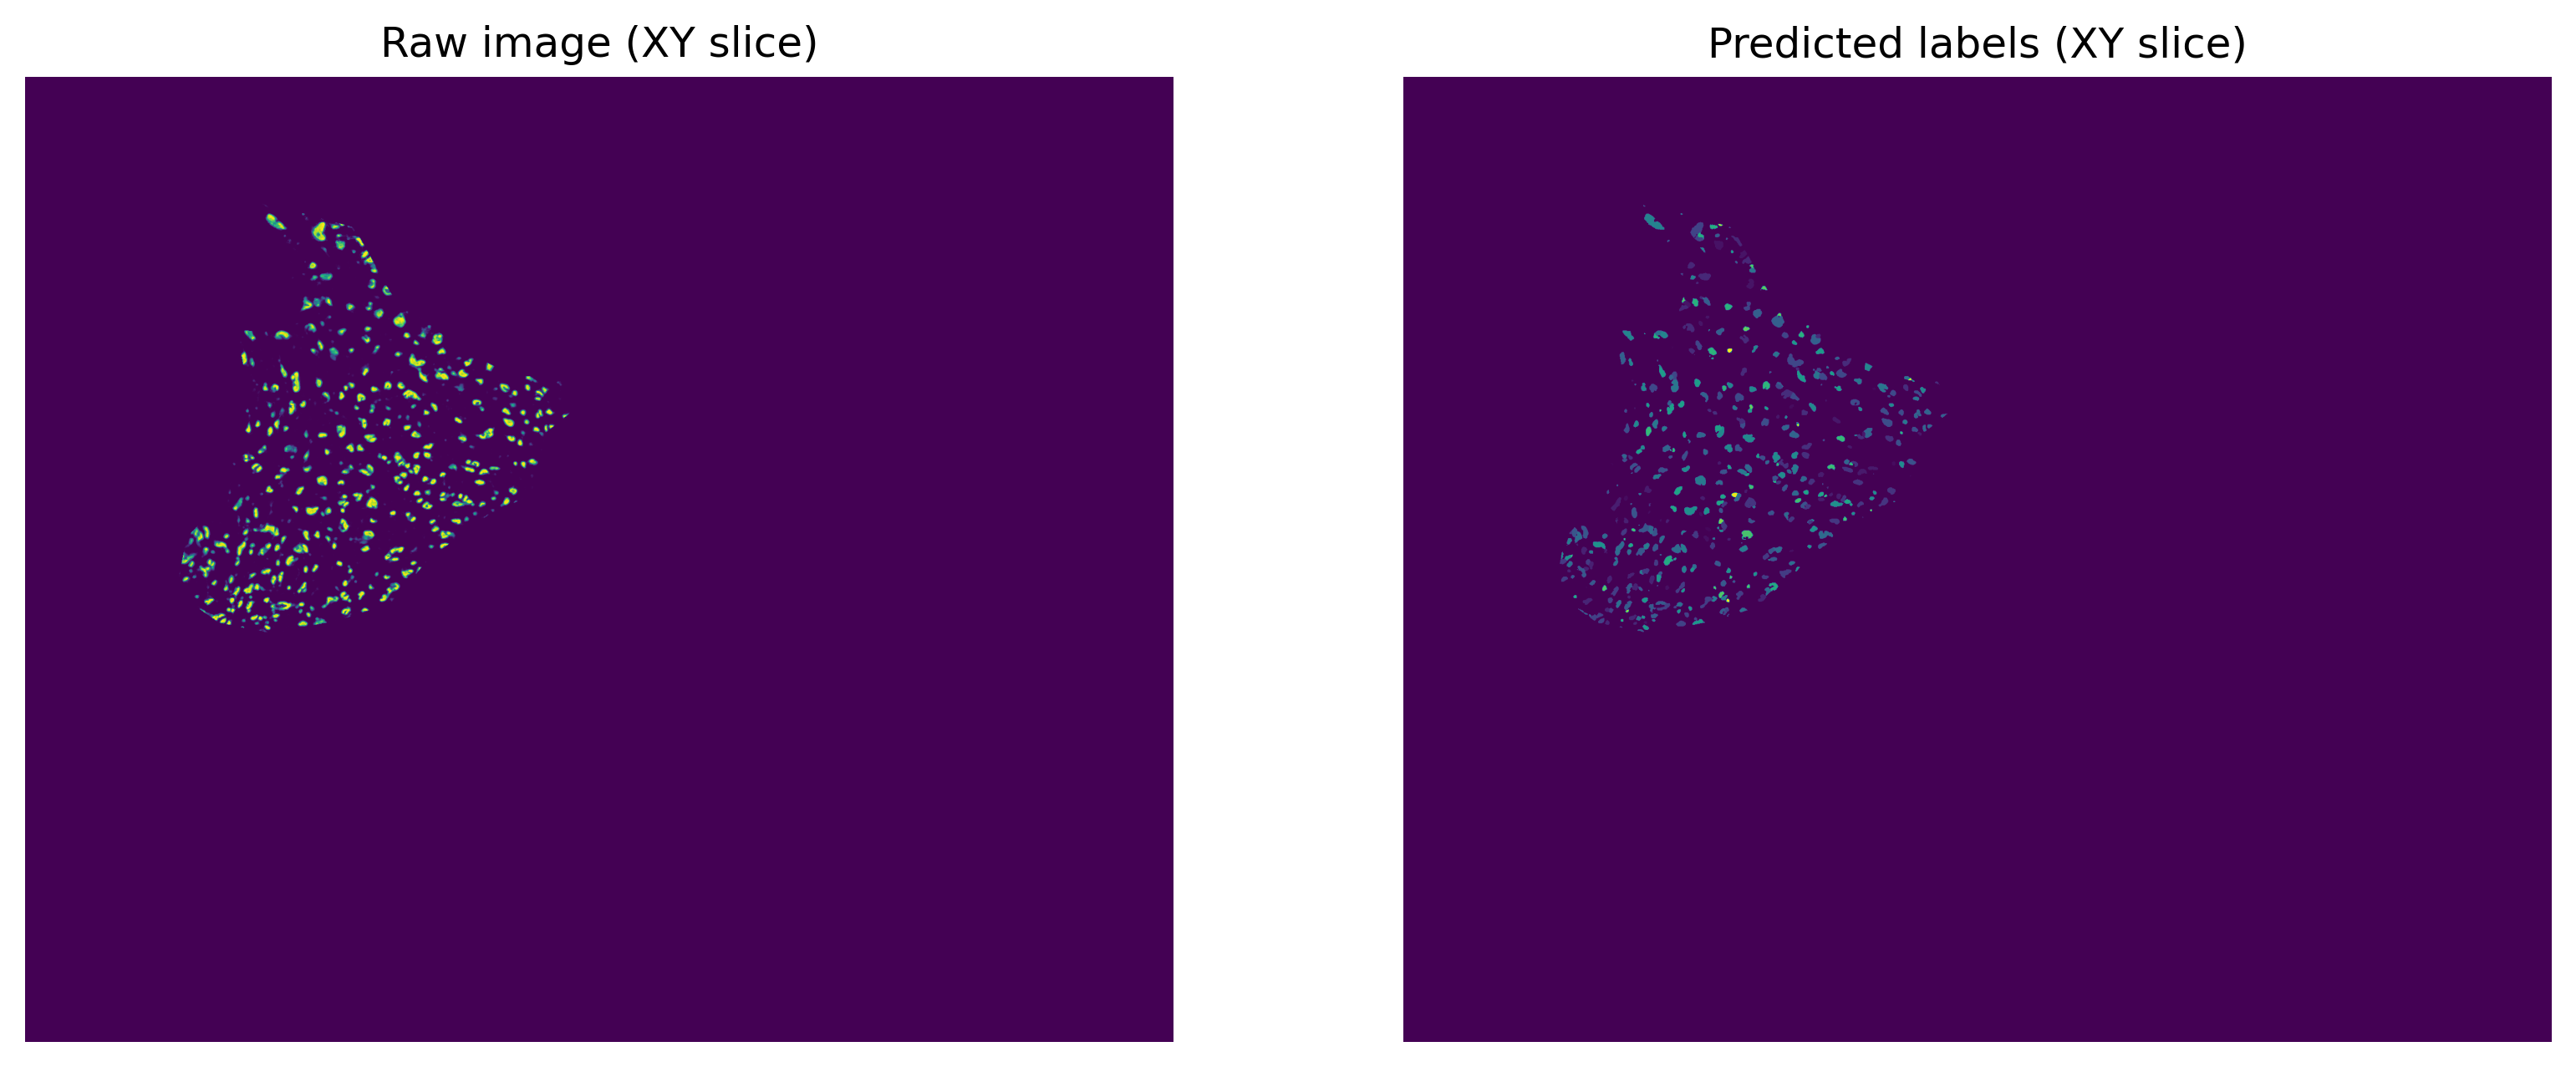

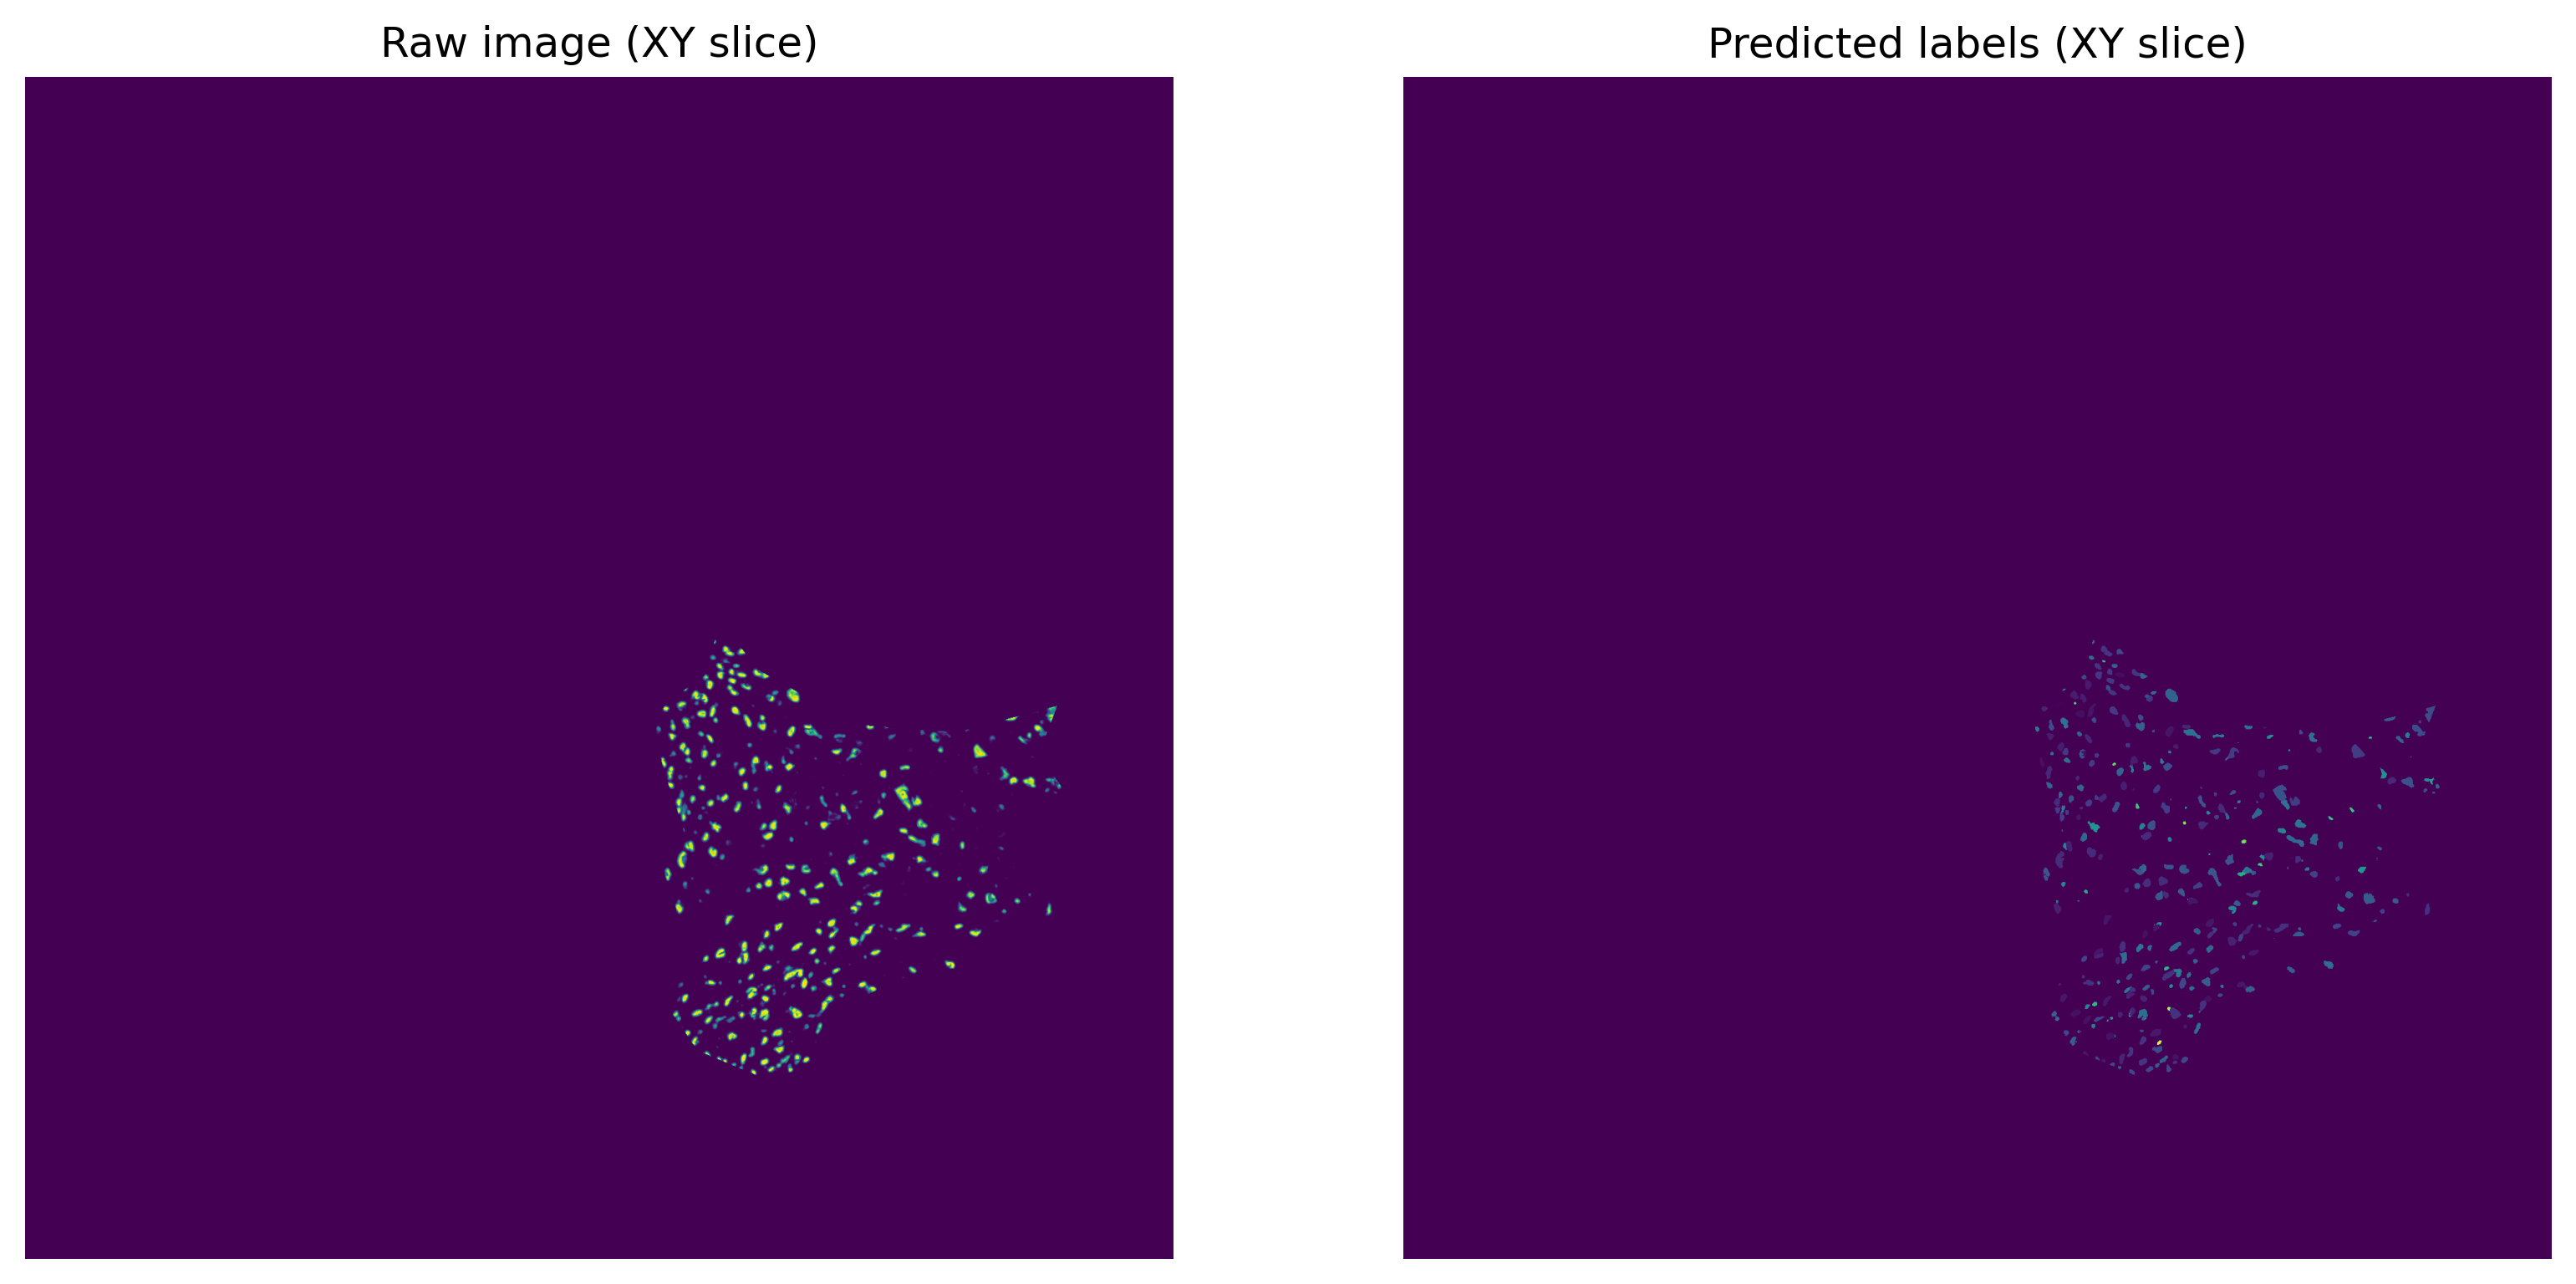

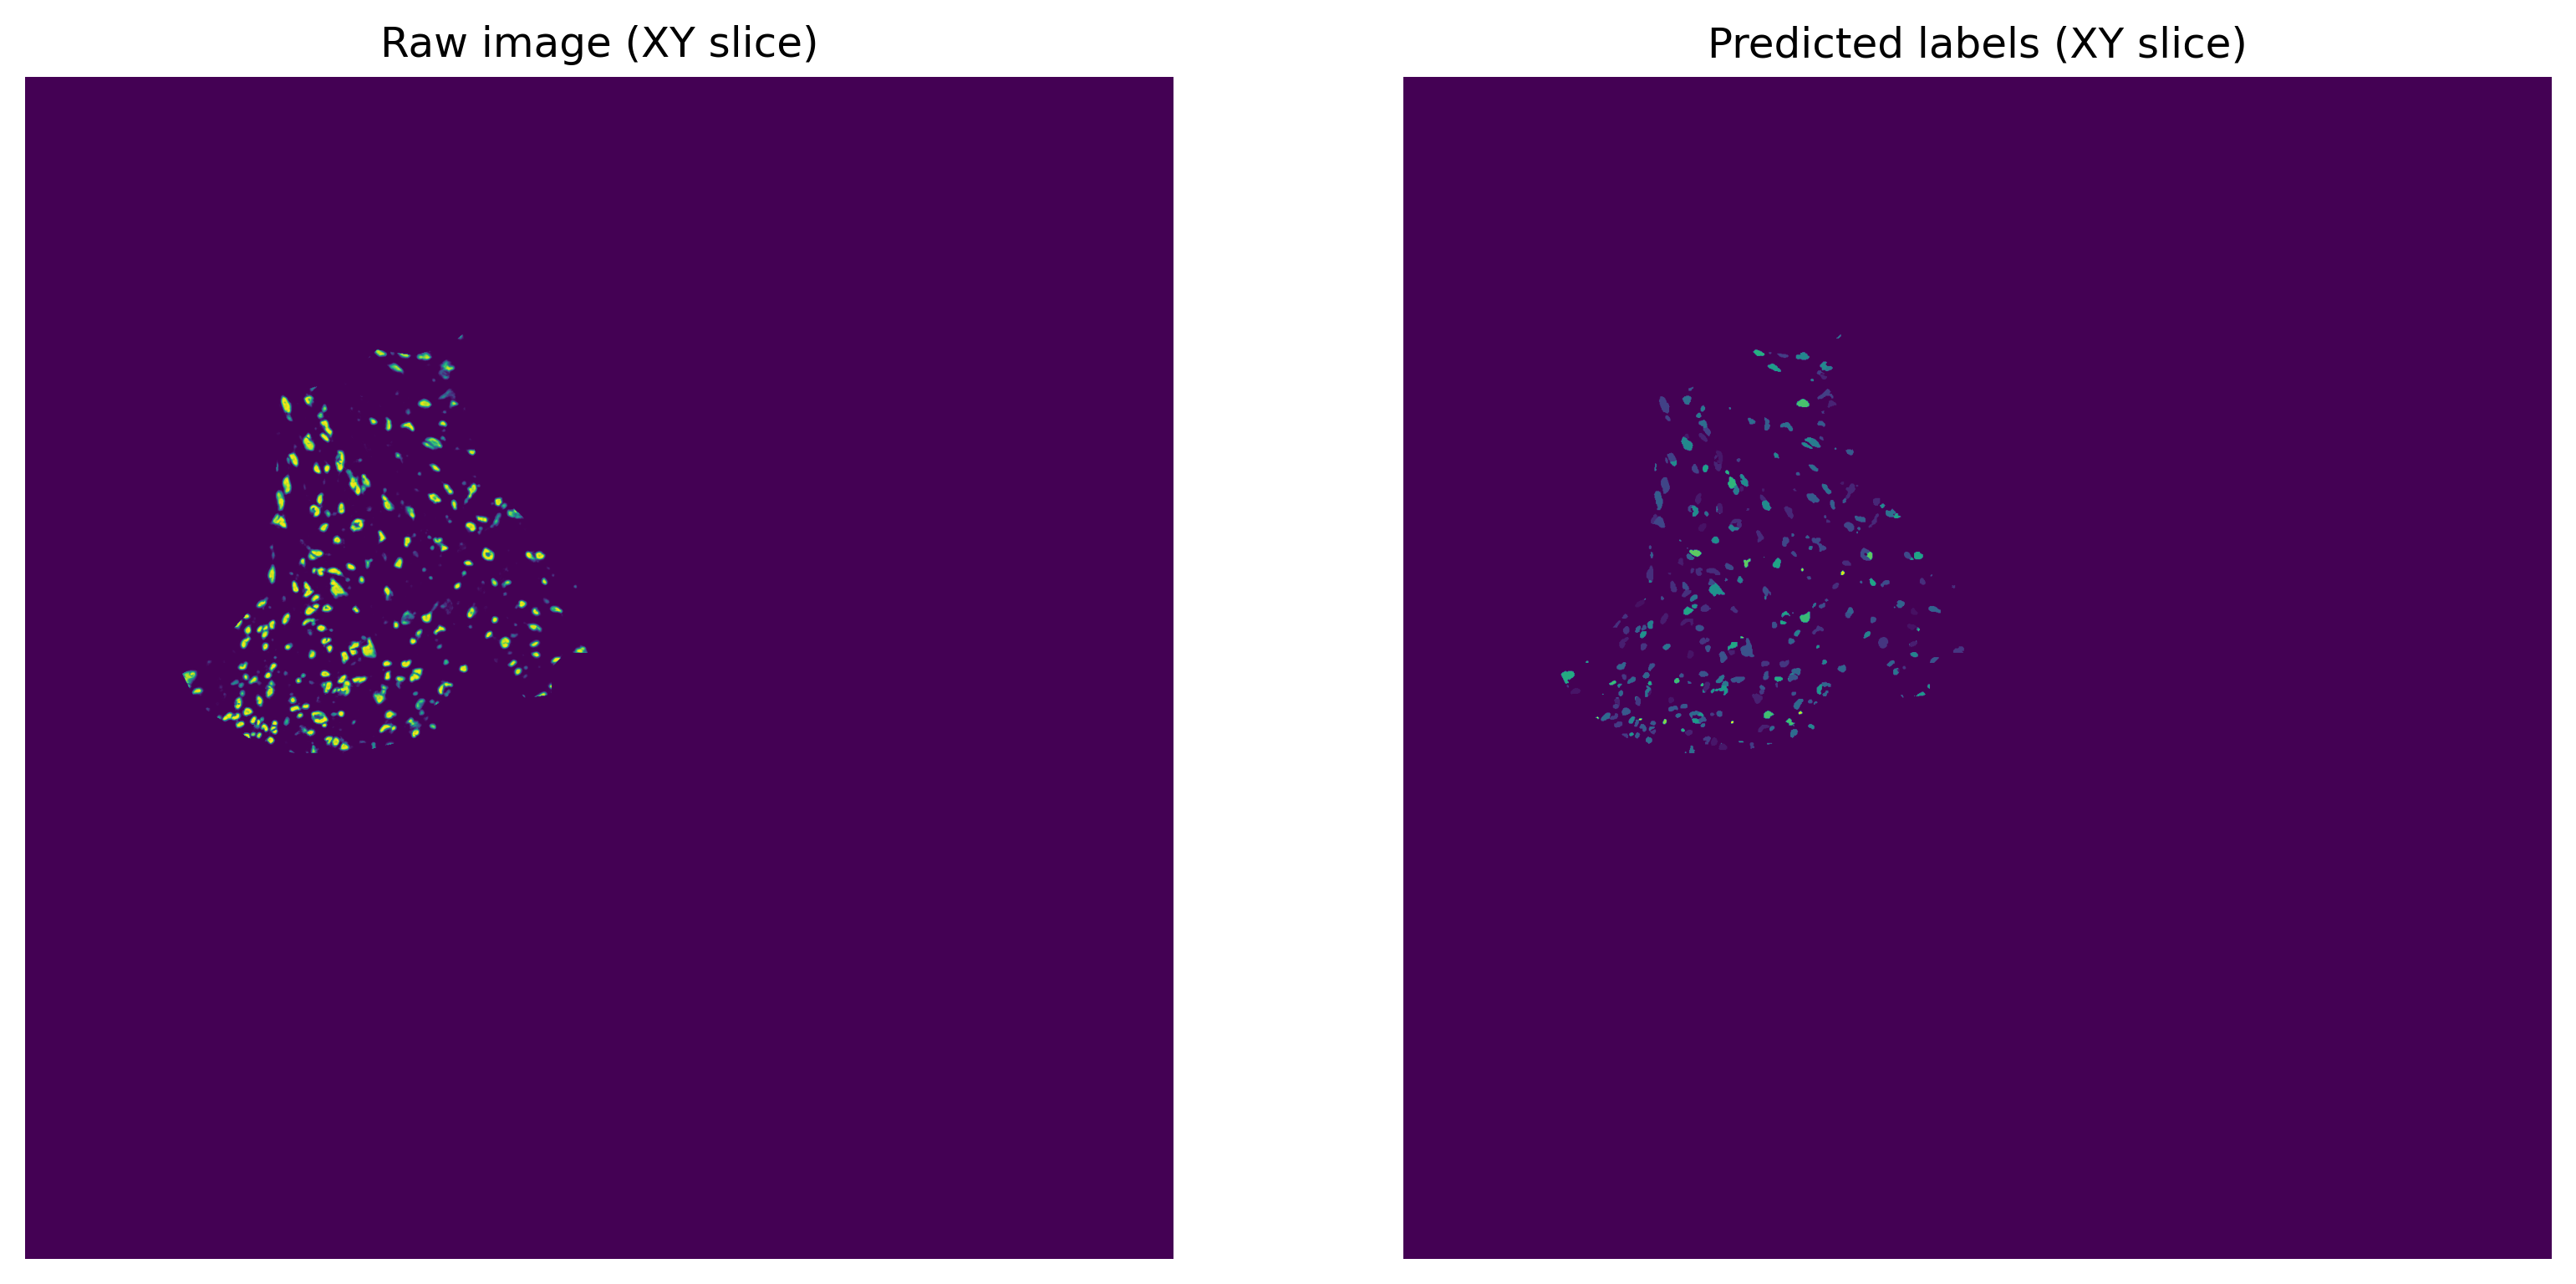

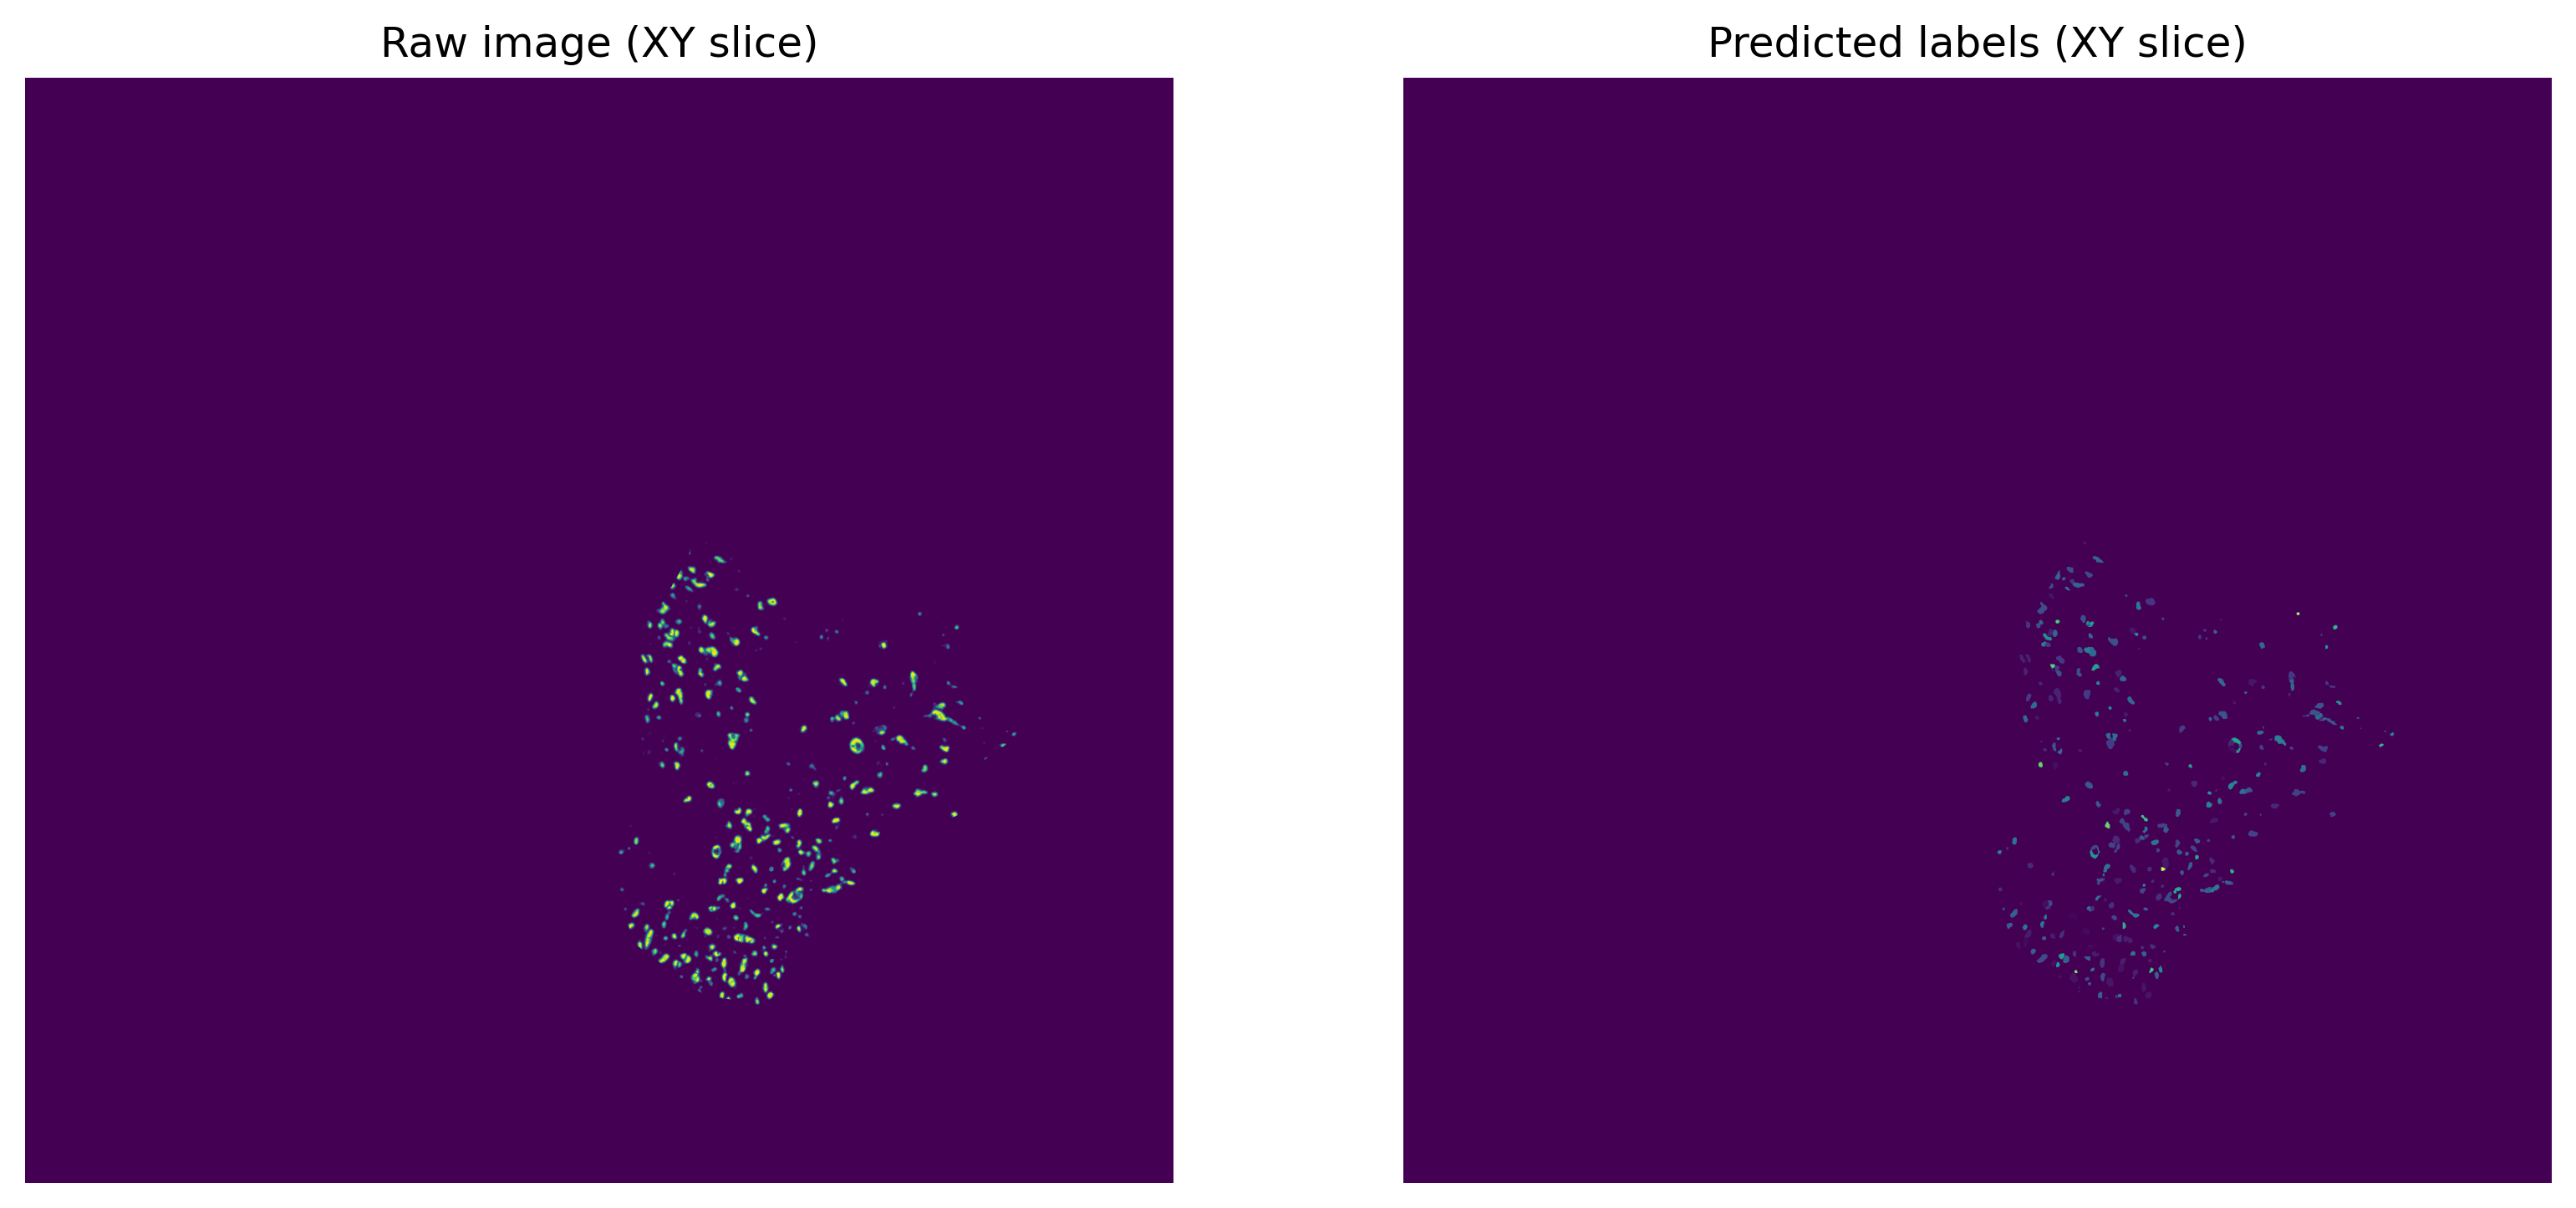

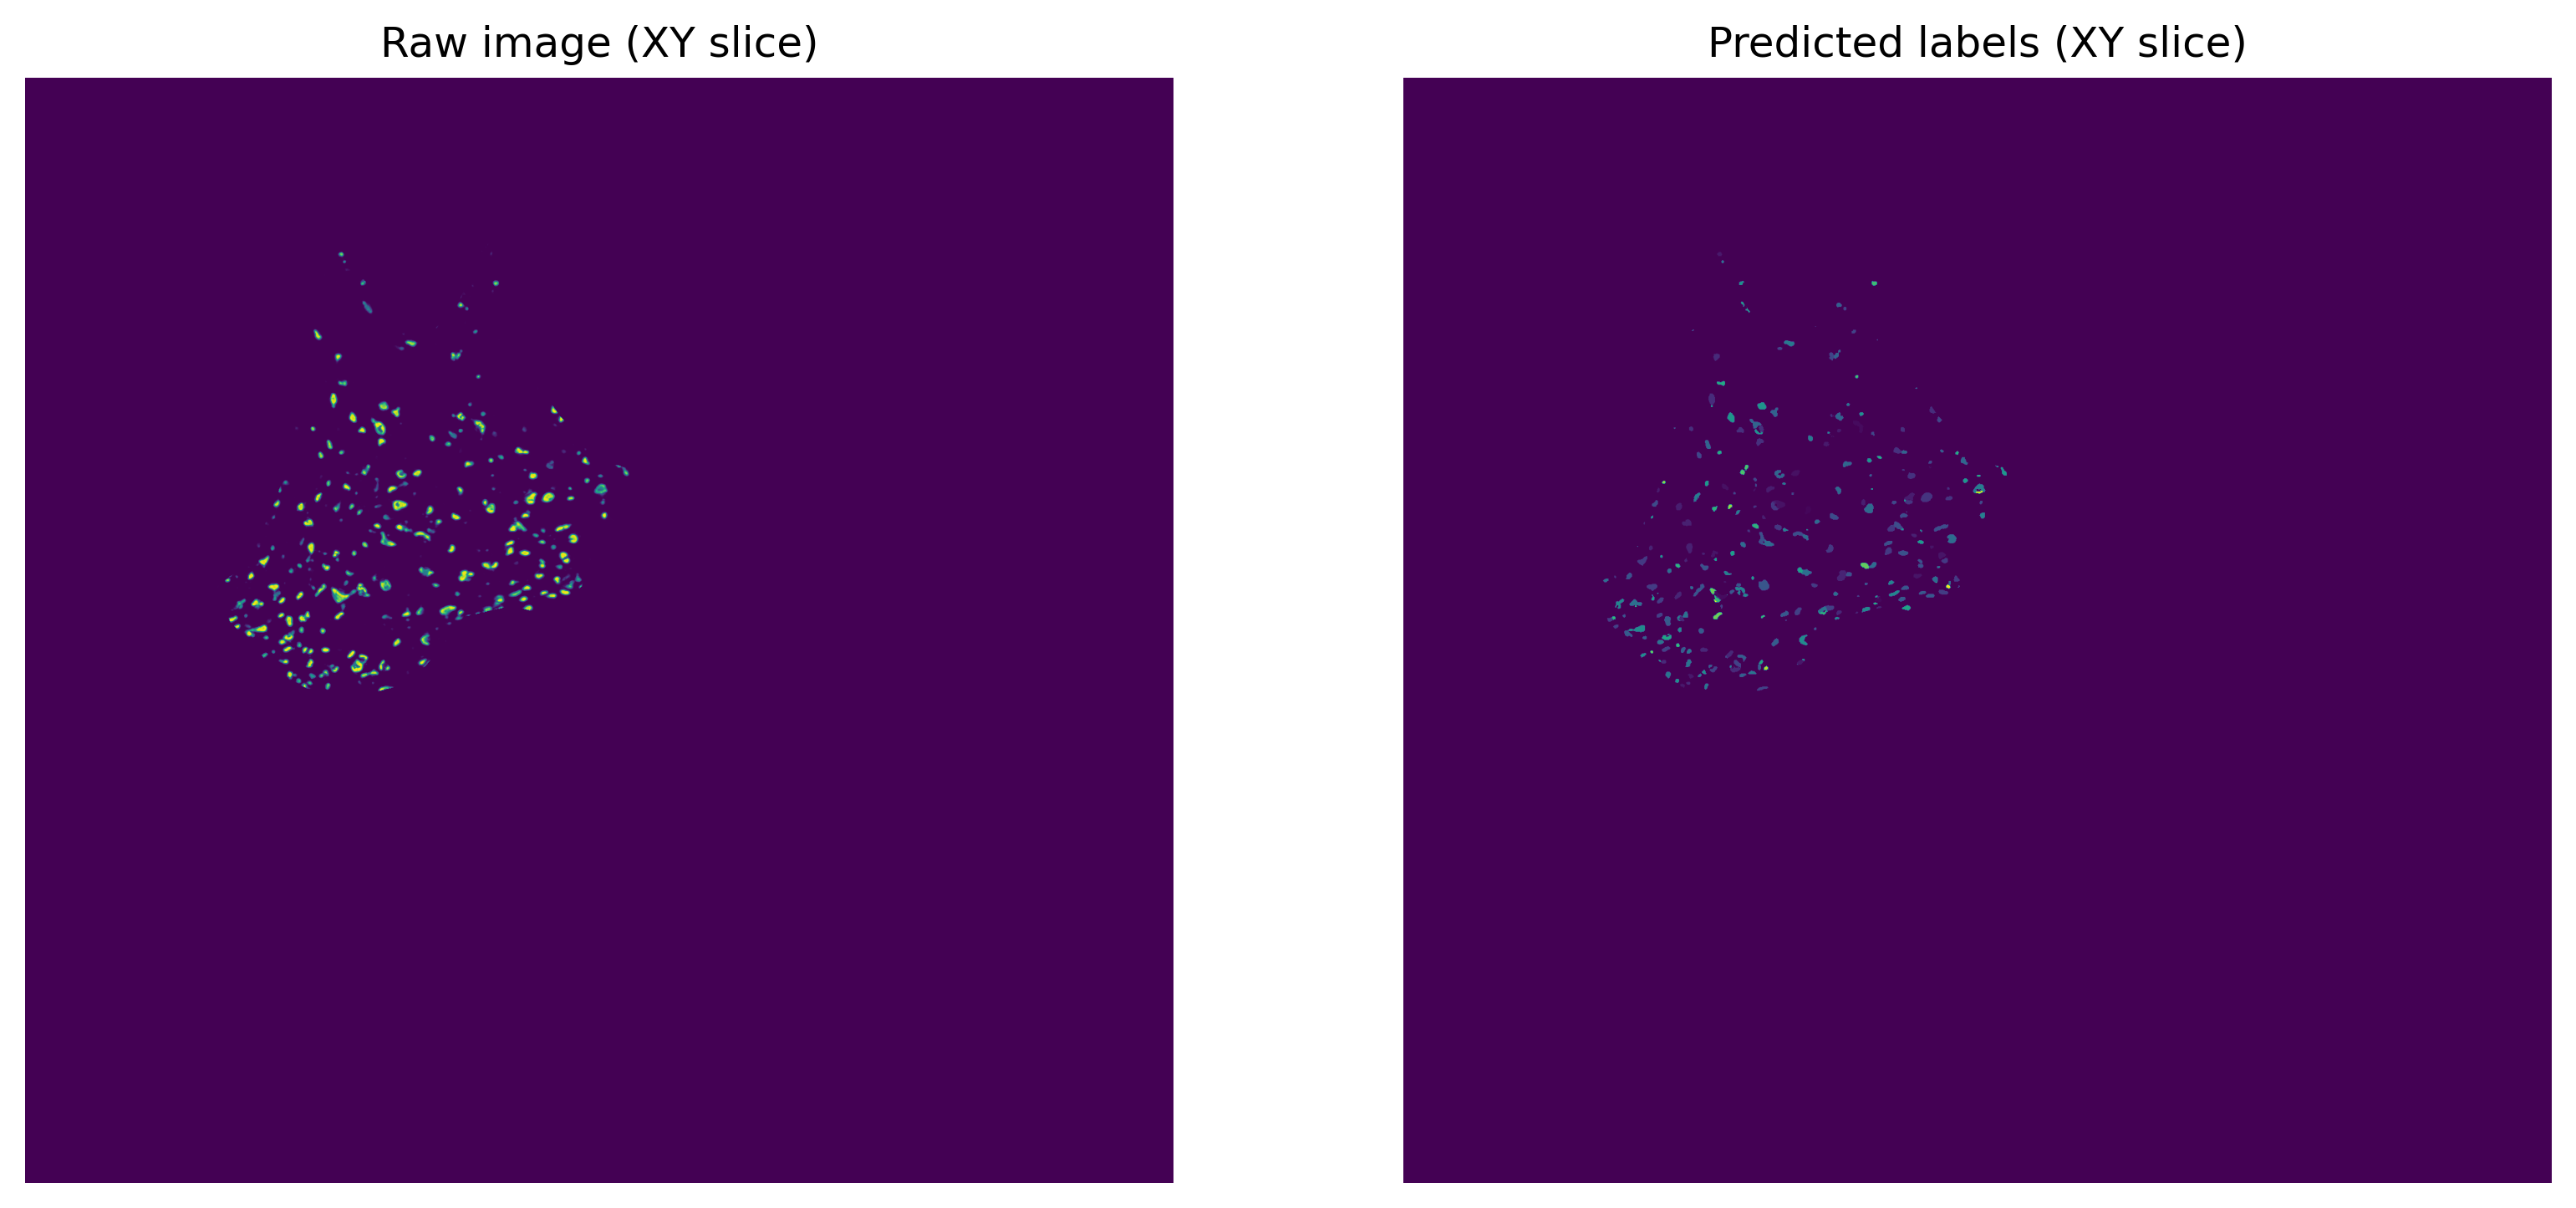

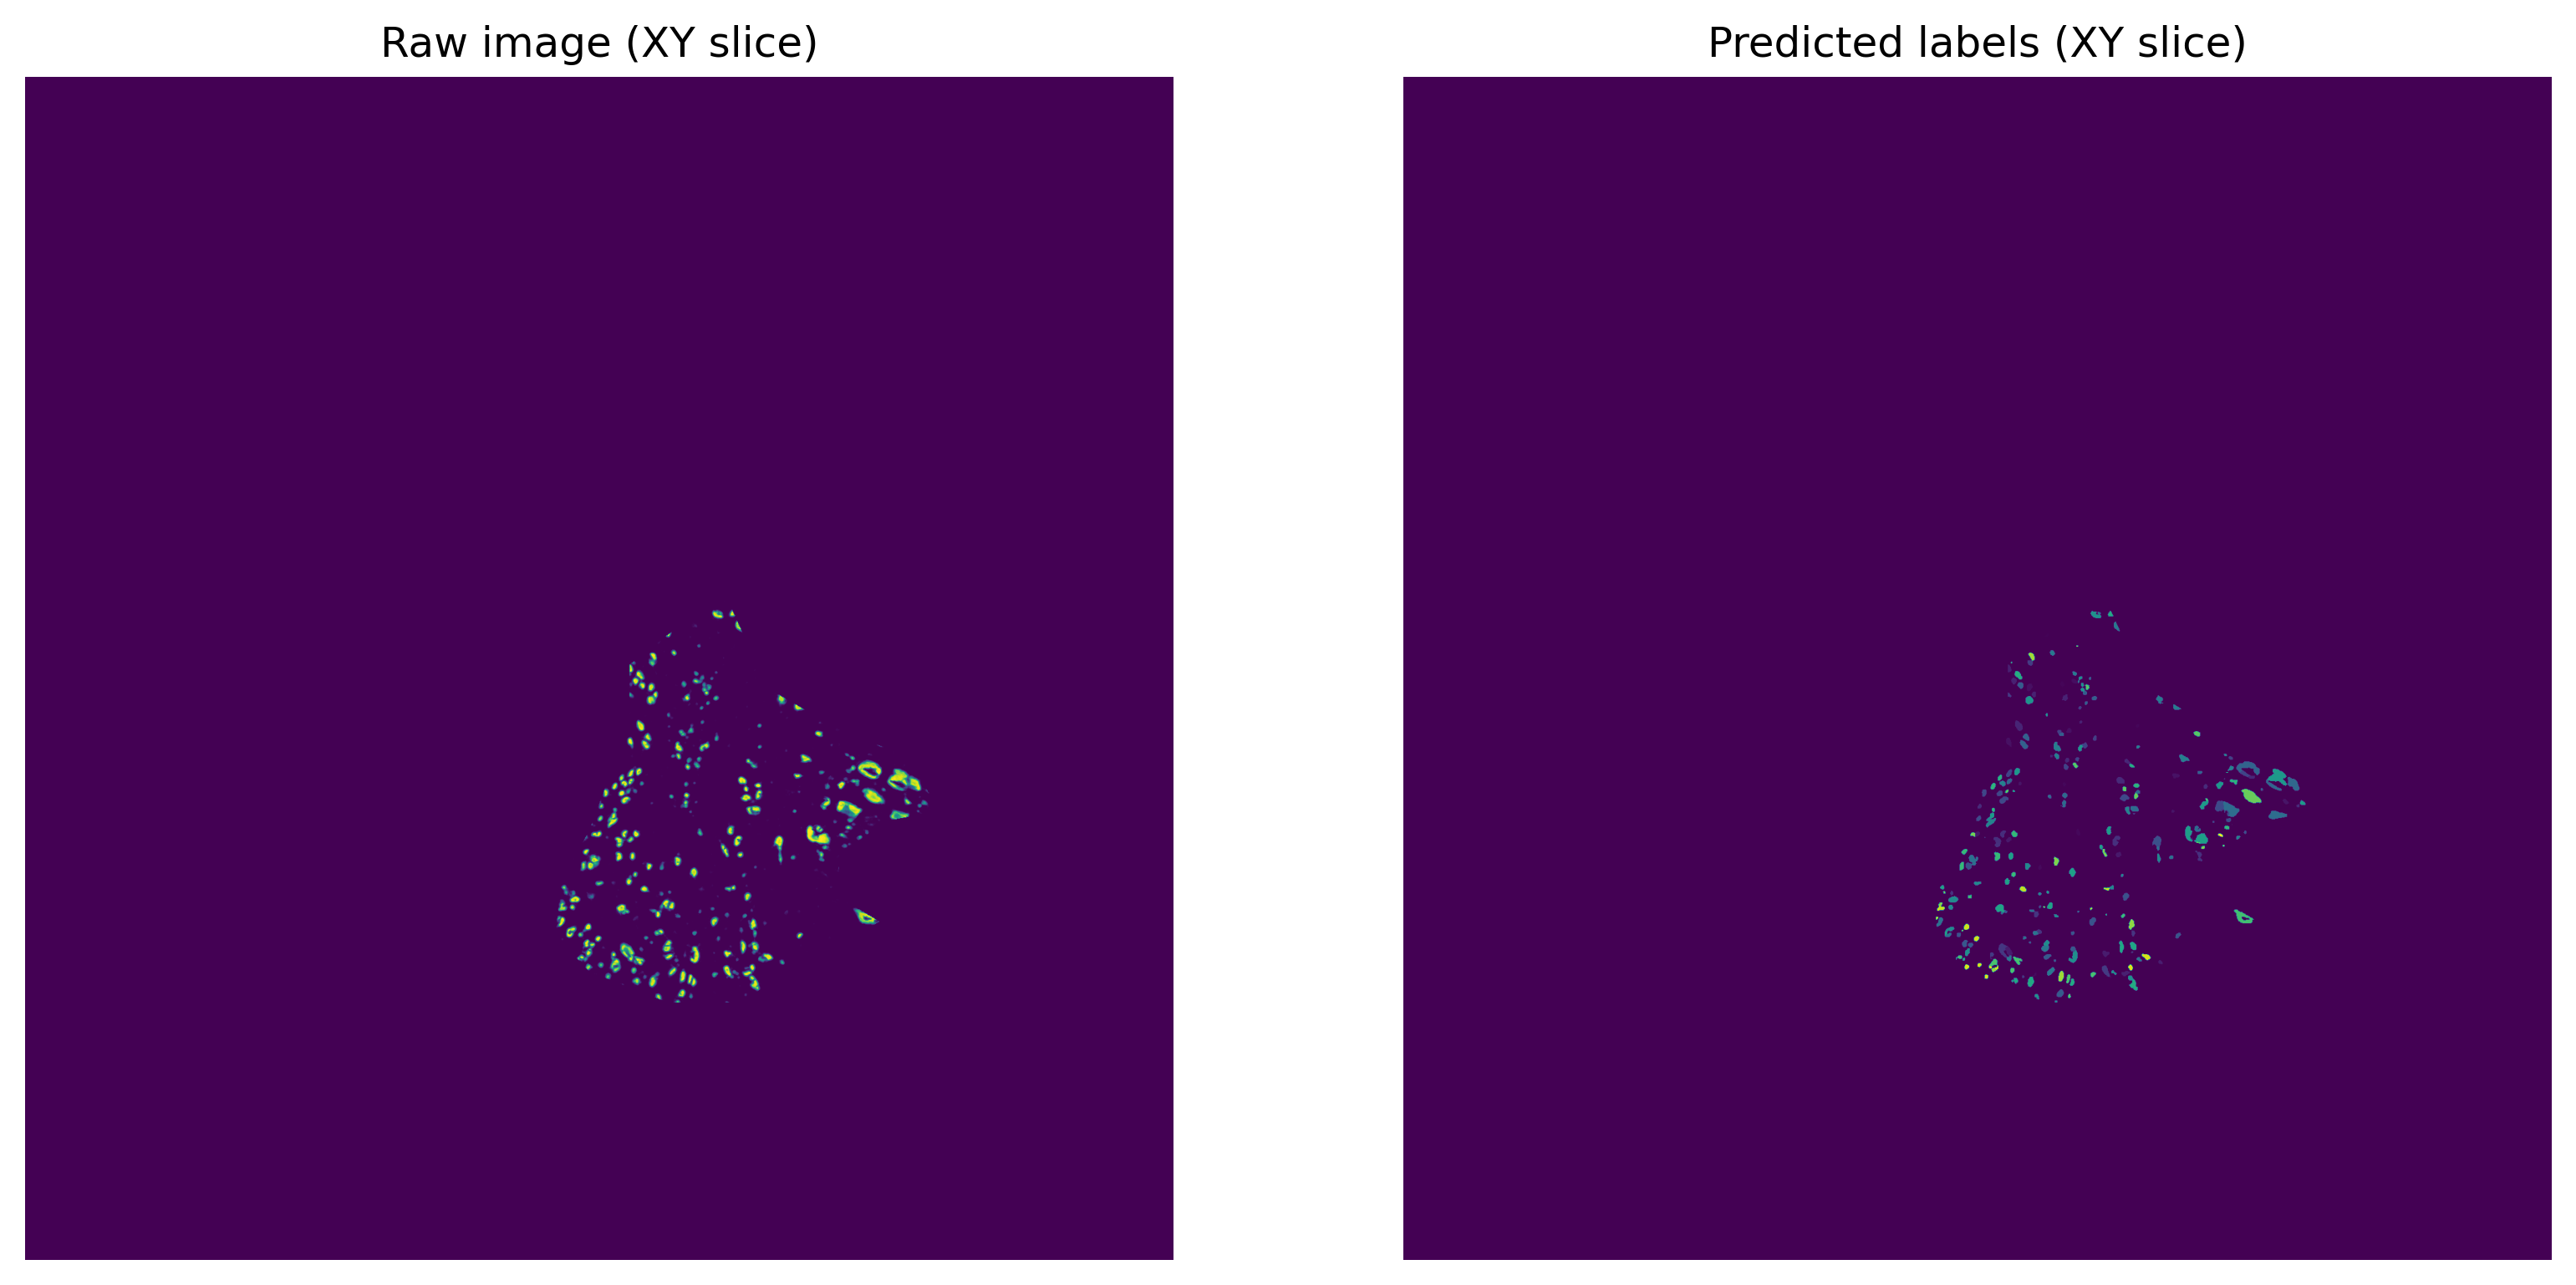

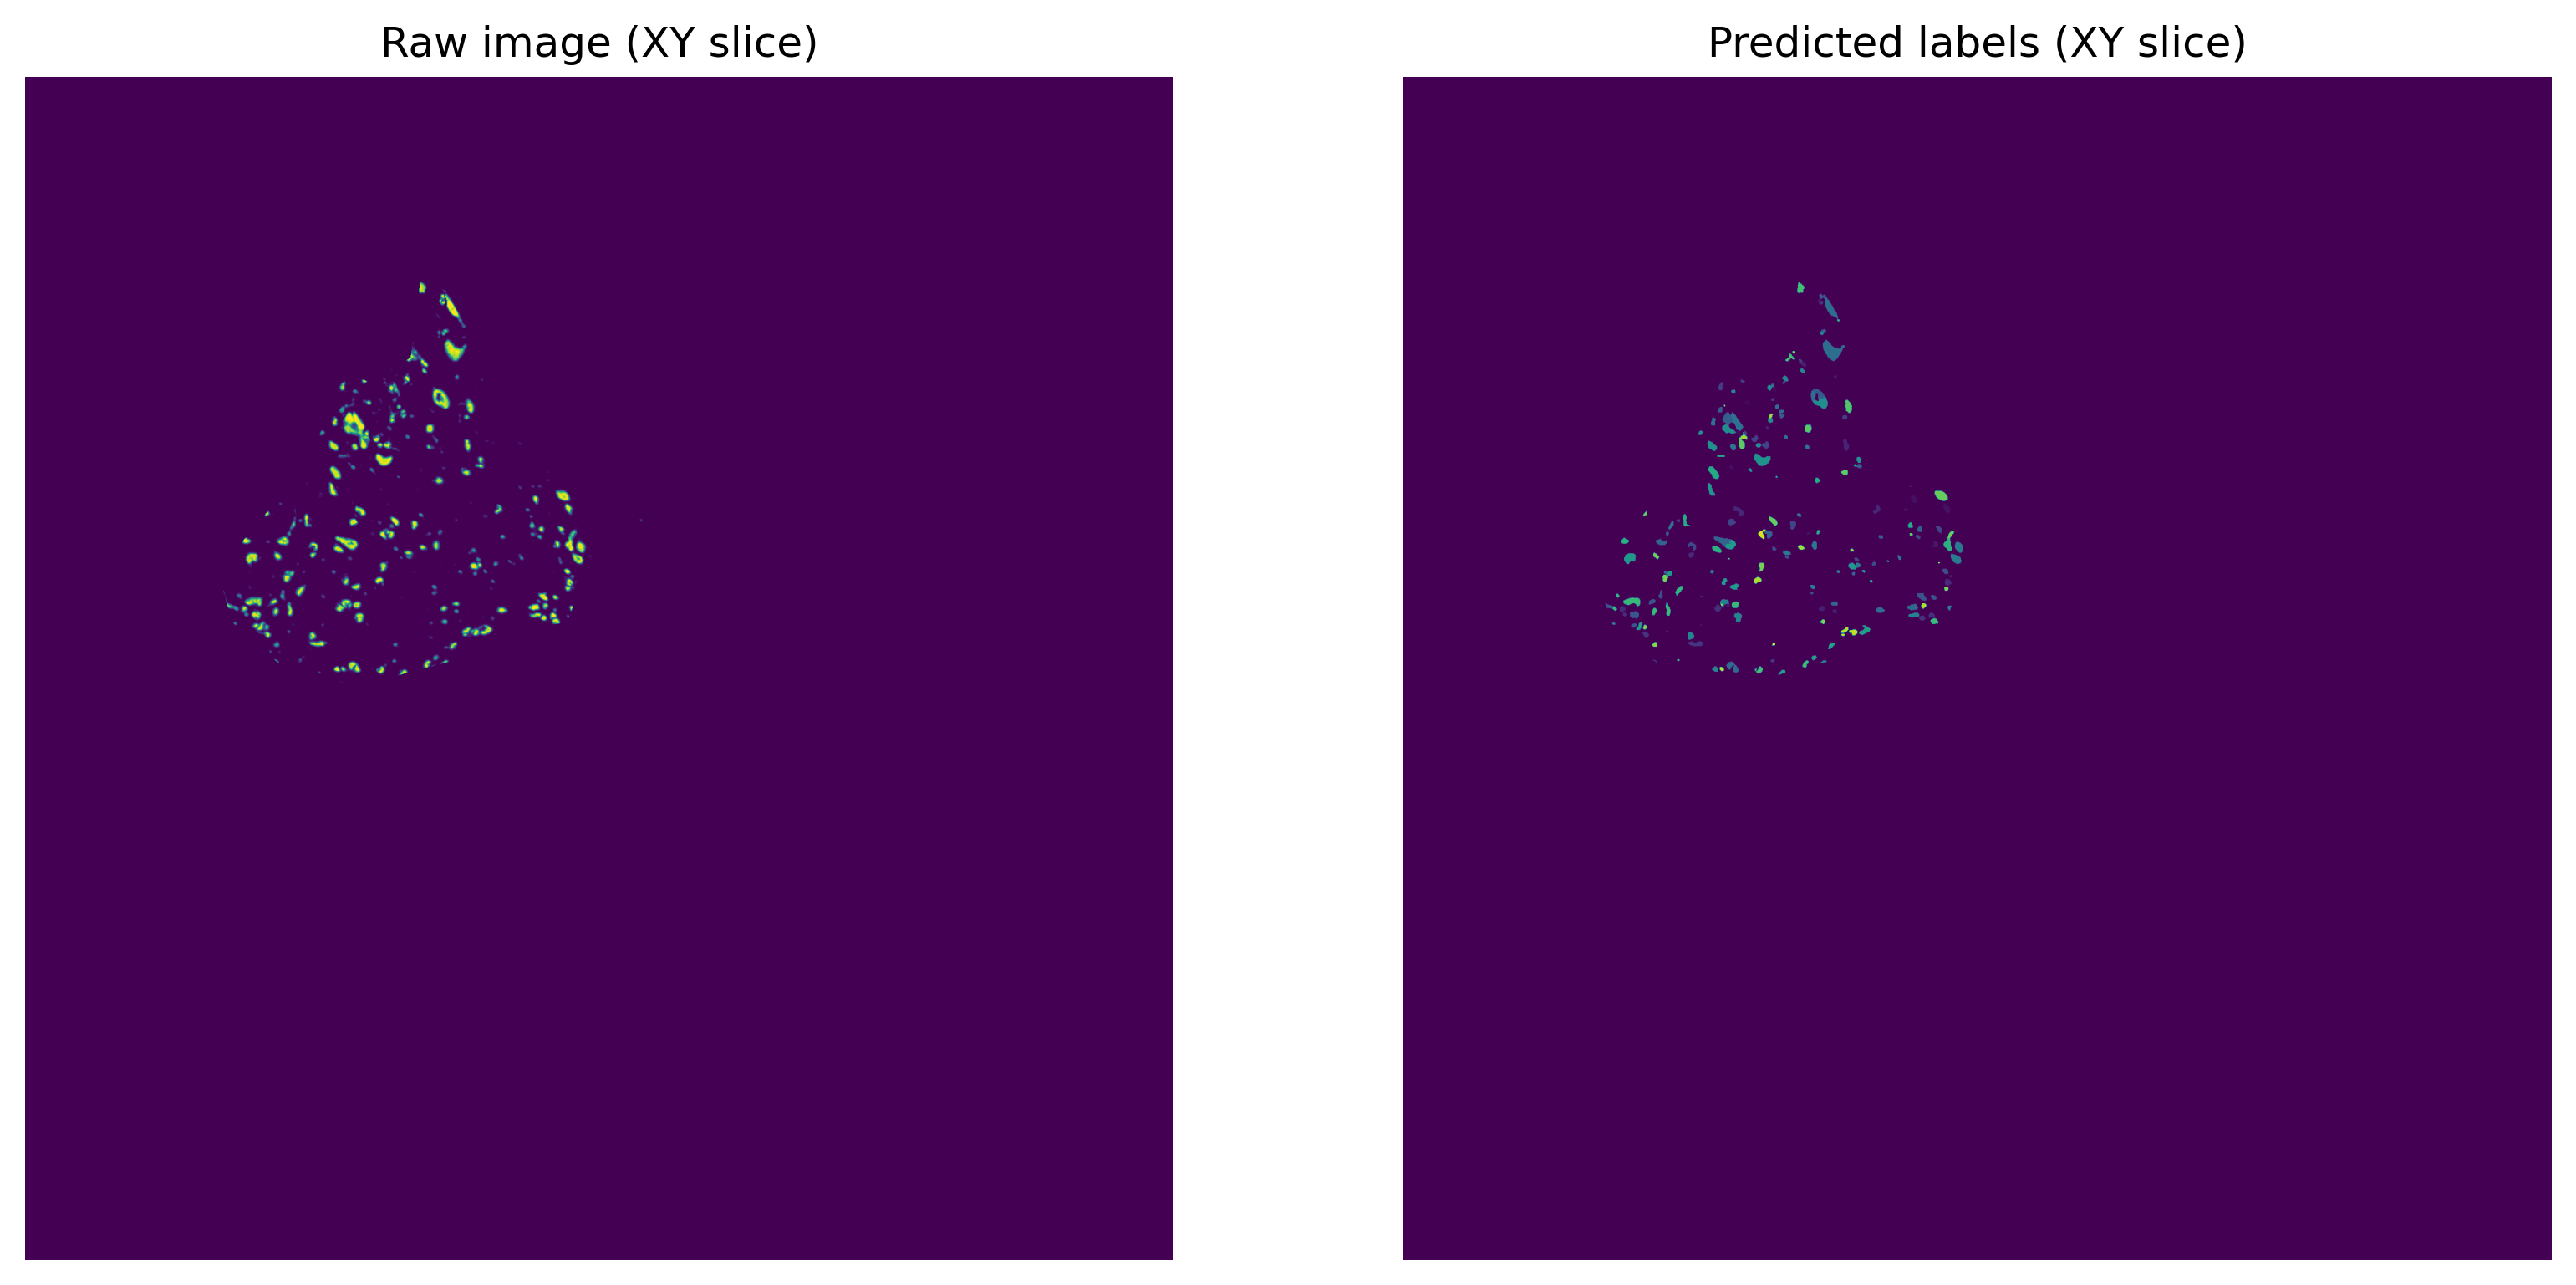

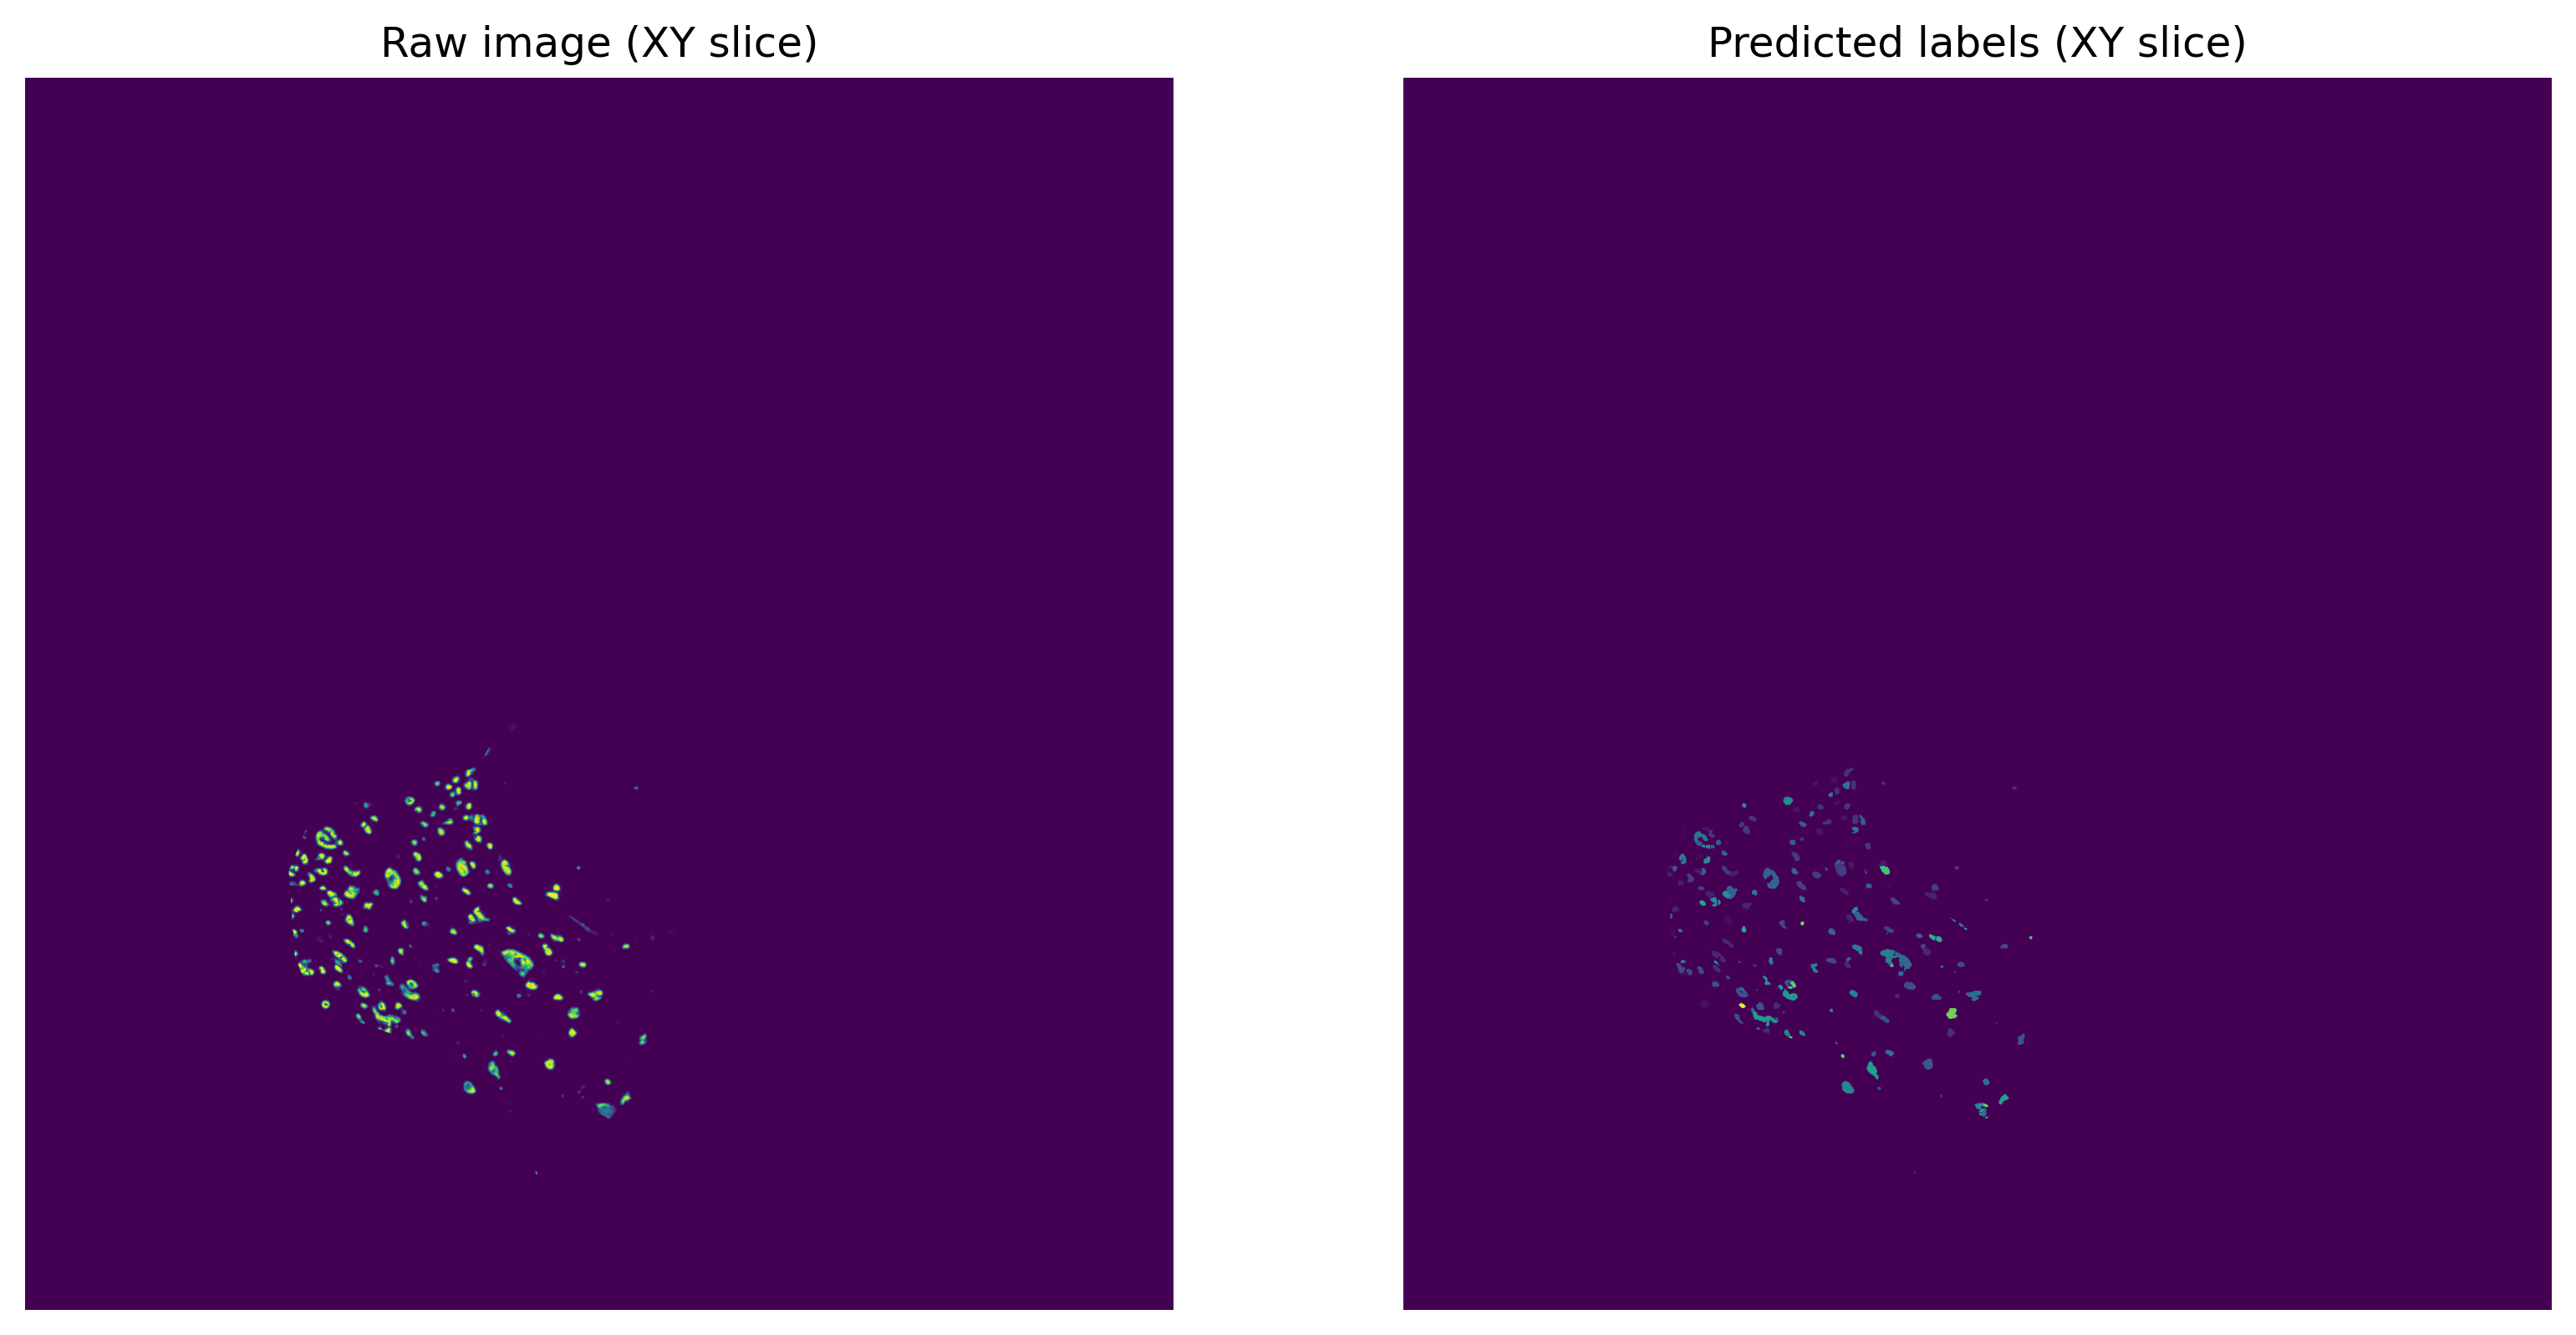

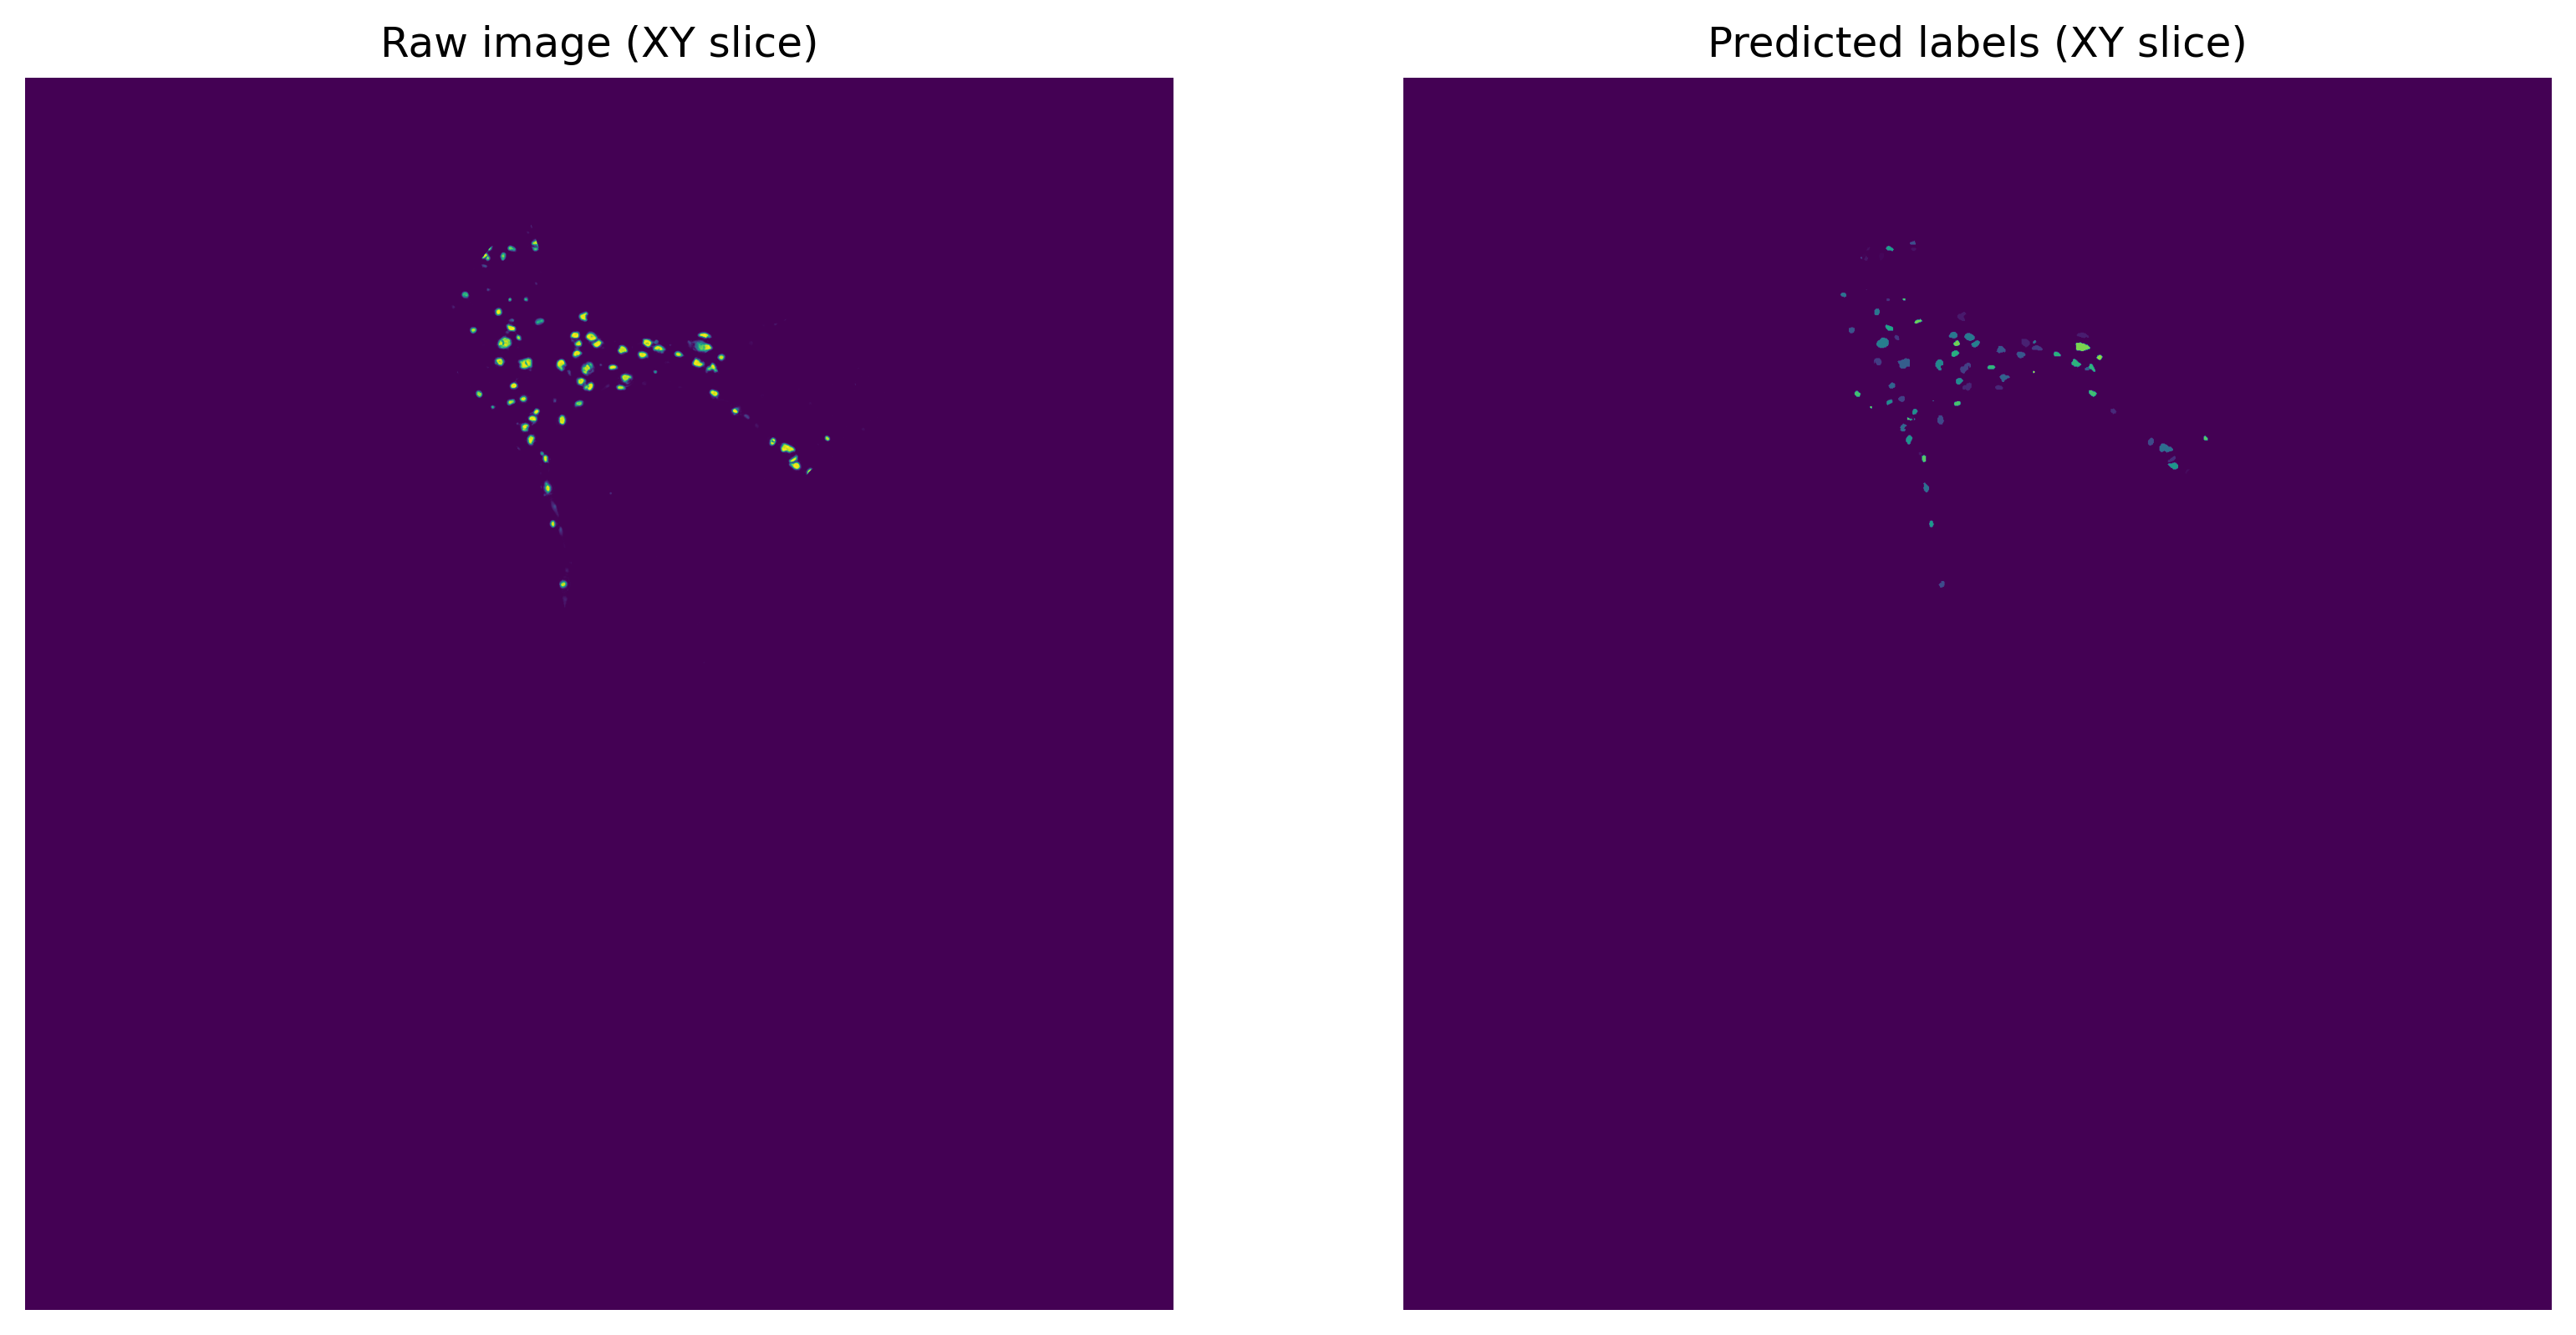

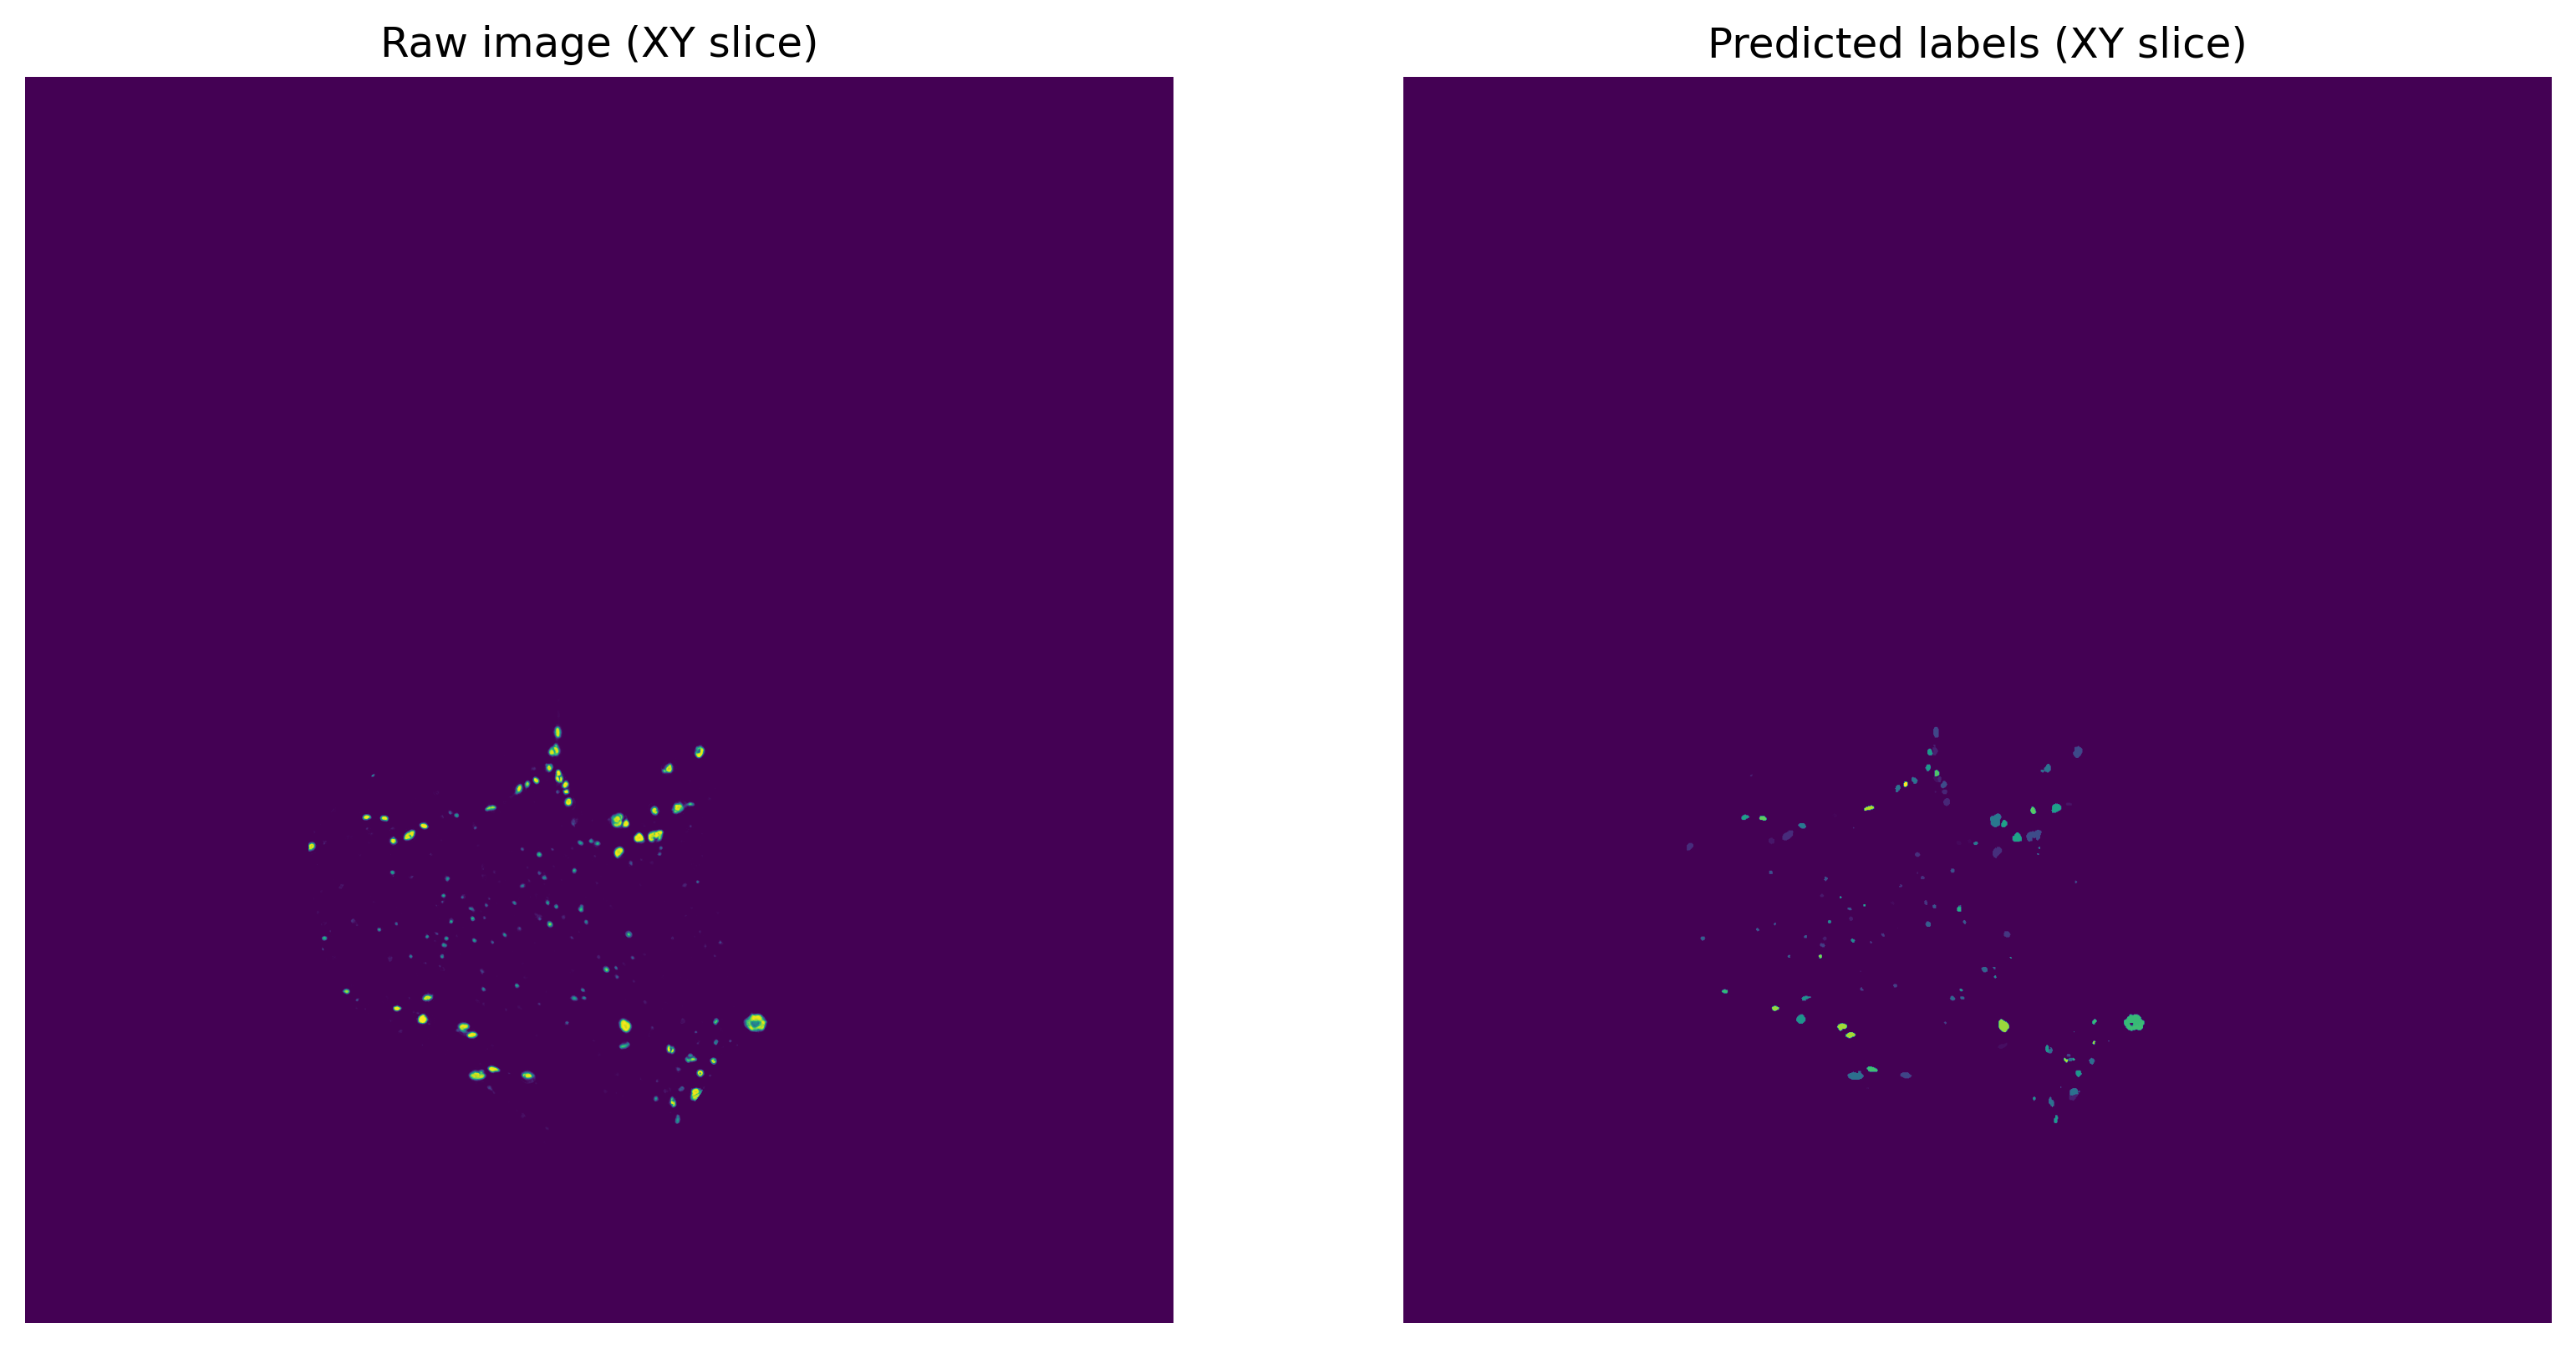

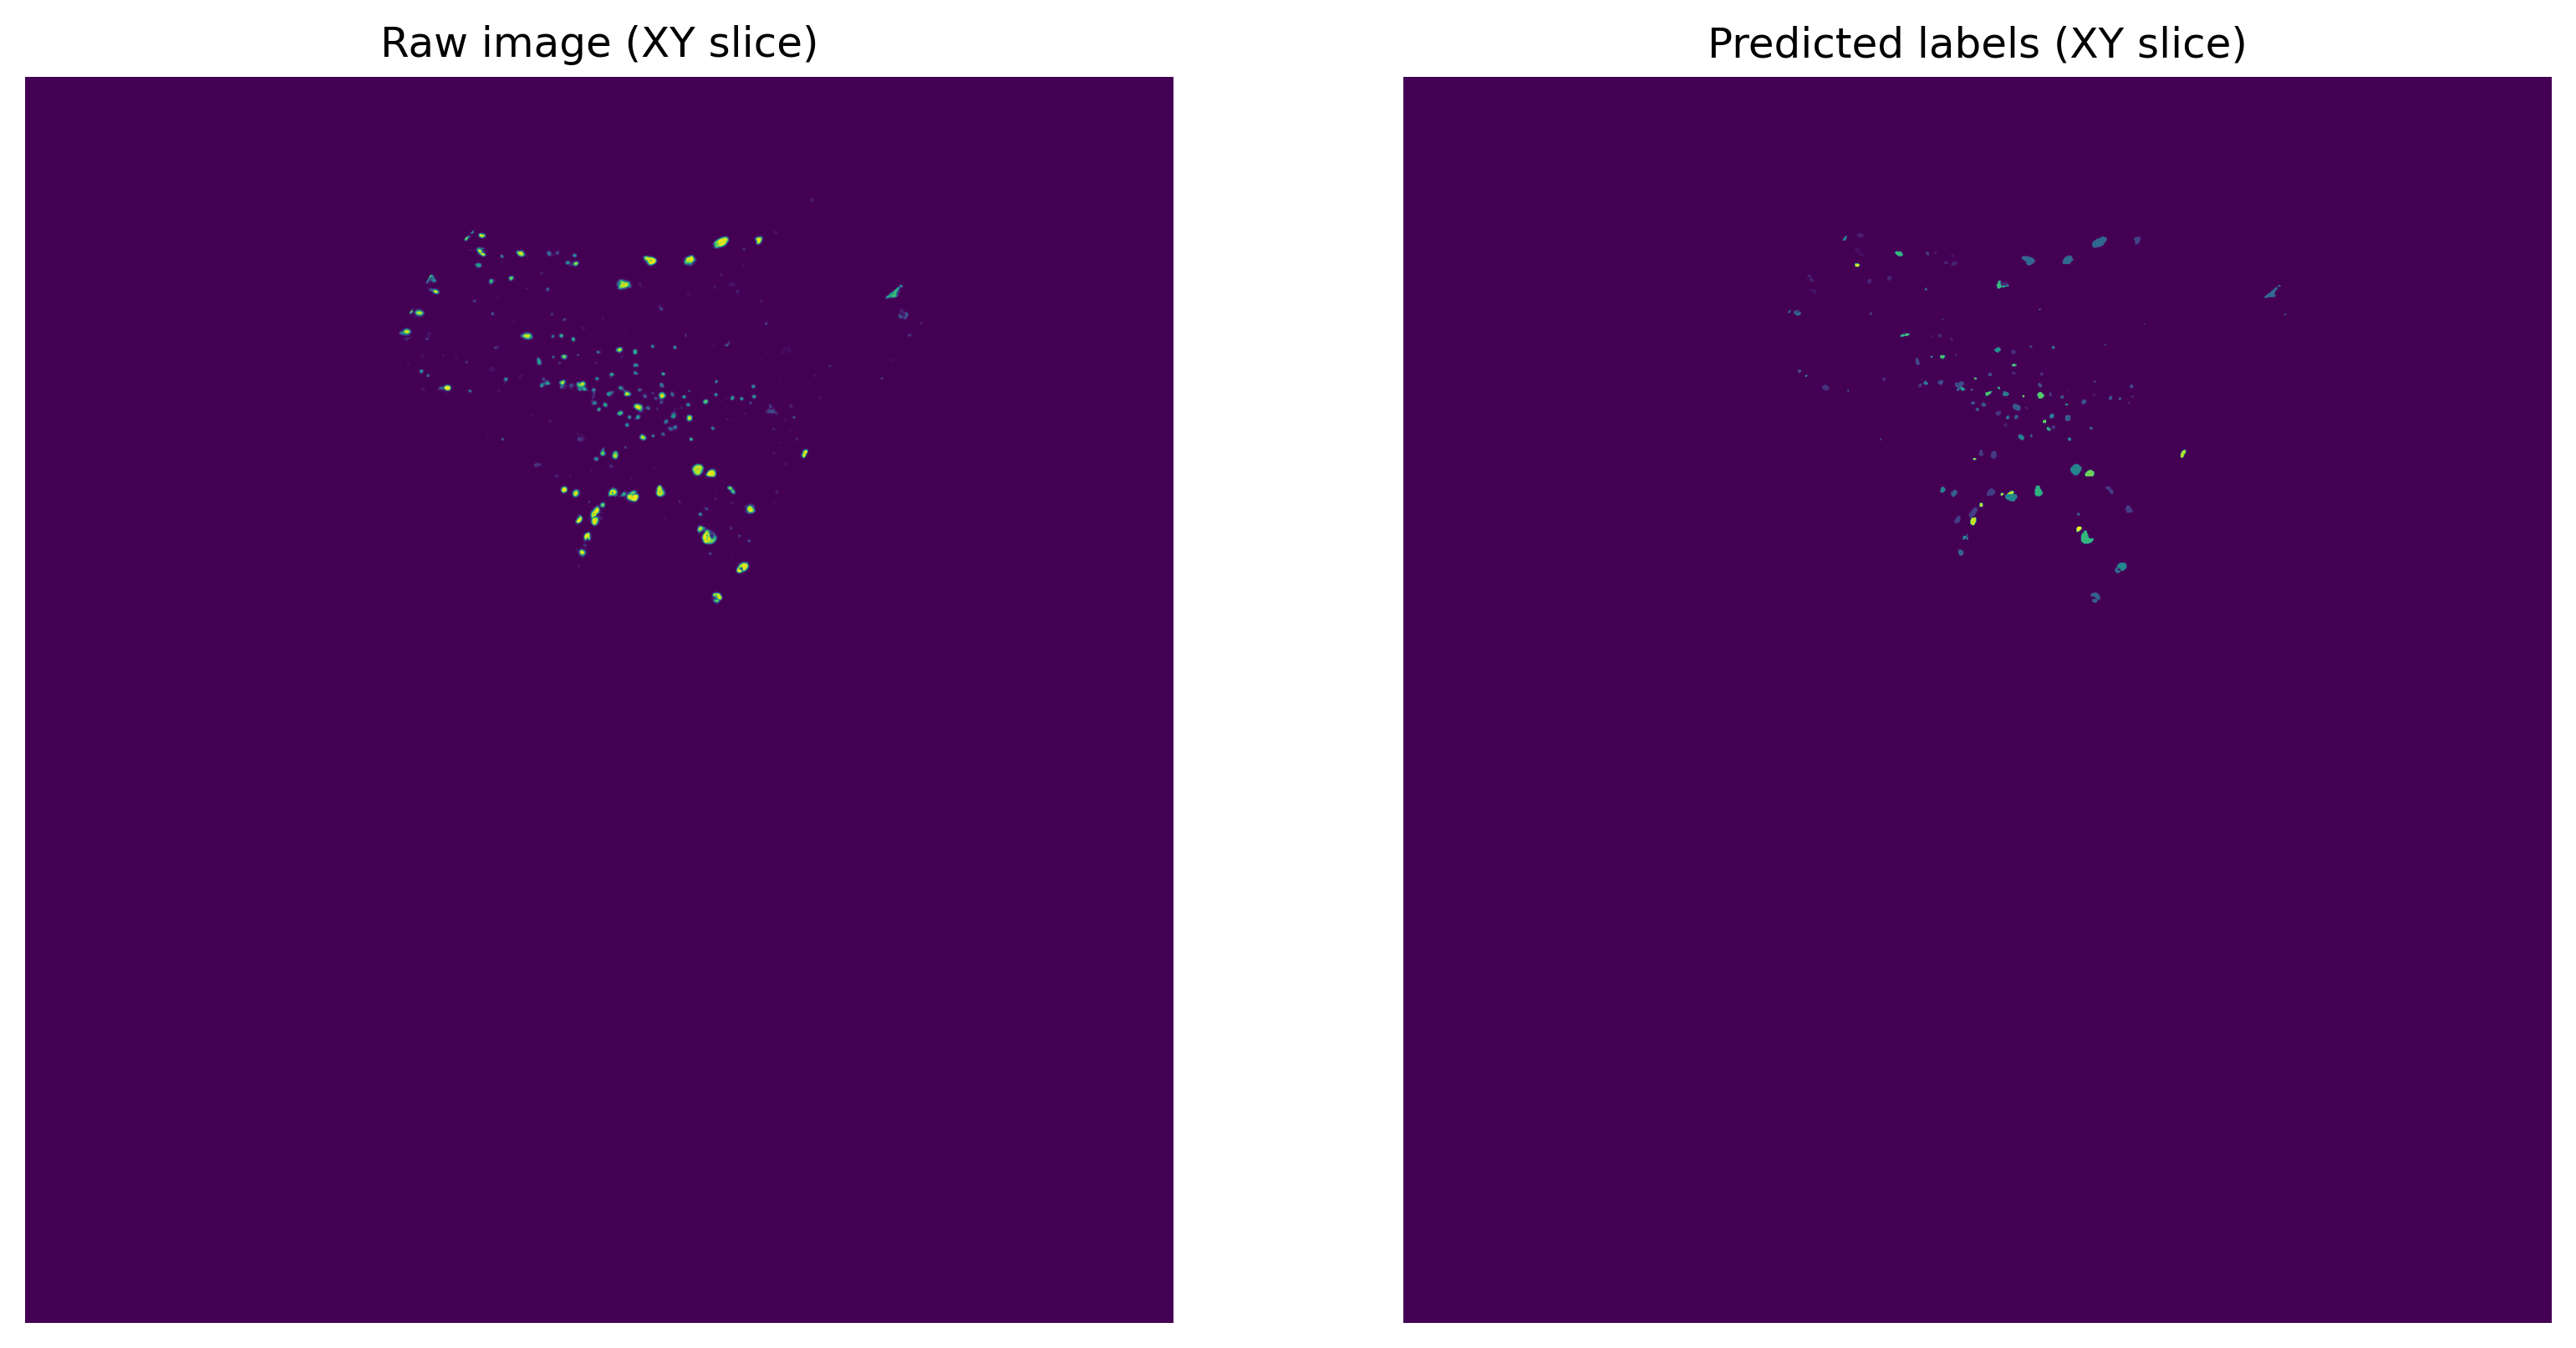

In [8]:
# Show the raw and the prediction as label image
if display_intermendiated_results == True:
    nimg = len(imgs)
    for idx in range(nimg):
        maski = masks[idx]
        flowi = flows[idx][0]
        img = imgs[idx] 
    
        plt.figure(figsize=(13,10))
        z = max(0, maski.shape[0] // 2 - 5)
        plt.subplot(121)
        plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
        plt.imshow(img[z])
        plt.title('Raw image (XY slice)')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
        plt.imshow(maski[z])
        plt.title('Predicted labels (XY slice)')
        plt.axis('off');

## Save the output label images as tif

In [9]:
# Create the output directory in the input path
def create_output_directory(output_path):
    output_path = os.path.join(results_dir,'OutPut_' + str(os.path.basename(os.path.normpath(results_dir))) + '_' + str(datetime.datetime.now()).replace(' ','_').replace('.','p').replace(':','T'))
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    return output_path

output_path = create_output_directory(results_dir)
print('Creatining OUTPUT directory:', output_path)

Creatining OUTPUT directory: D:/Data/External/NaemiKuehn/2022-04-07/3DROIsforCellPose/O\OutPut_O_2022-04-20_03T41T48p078556


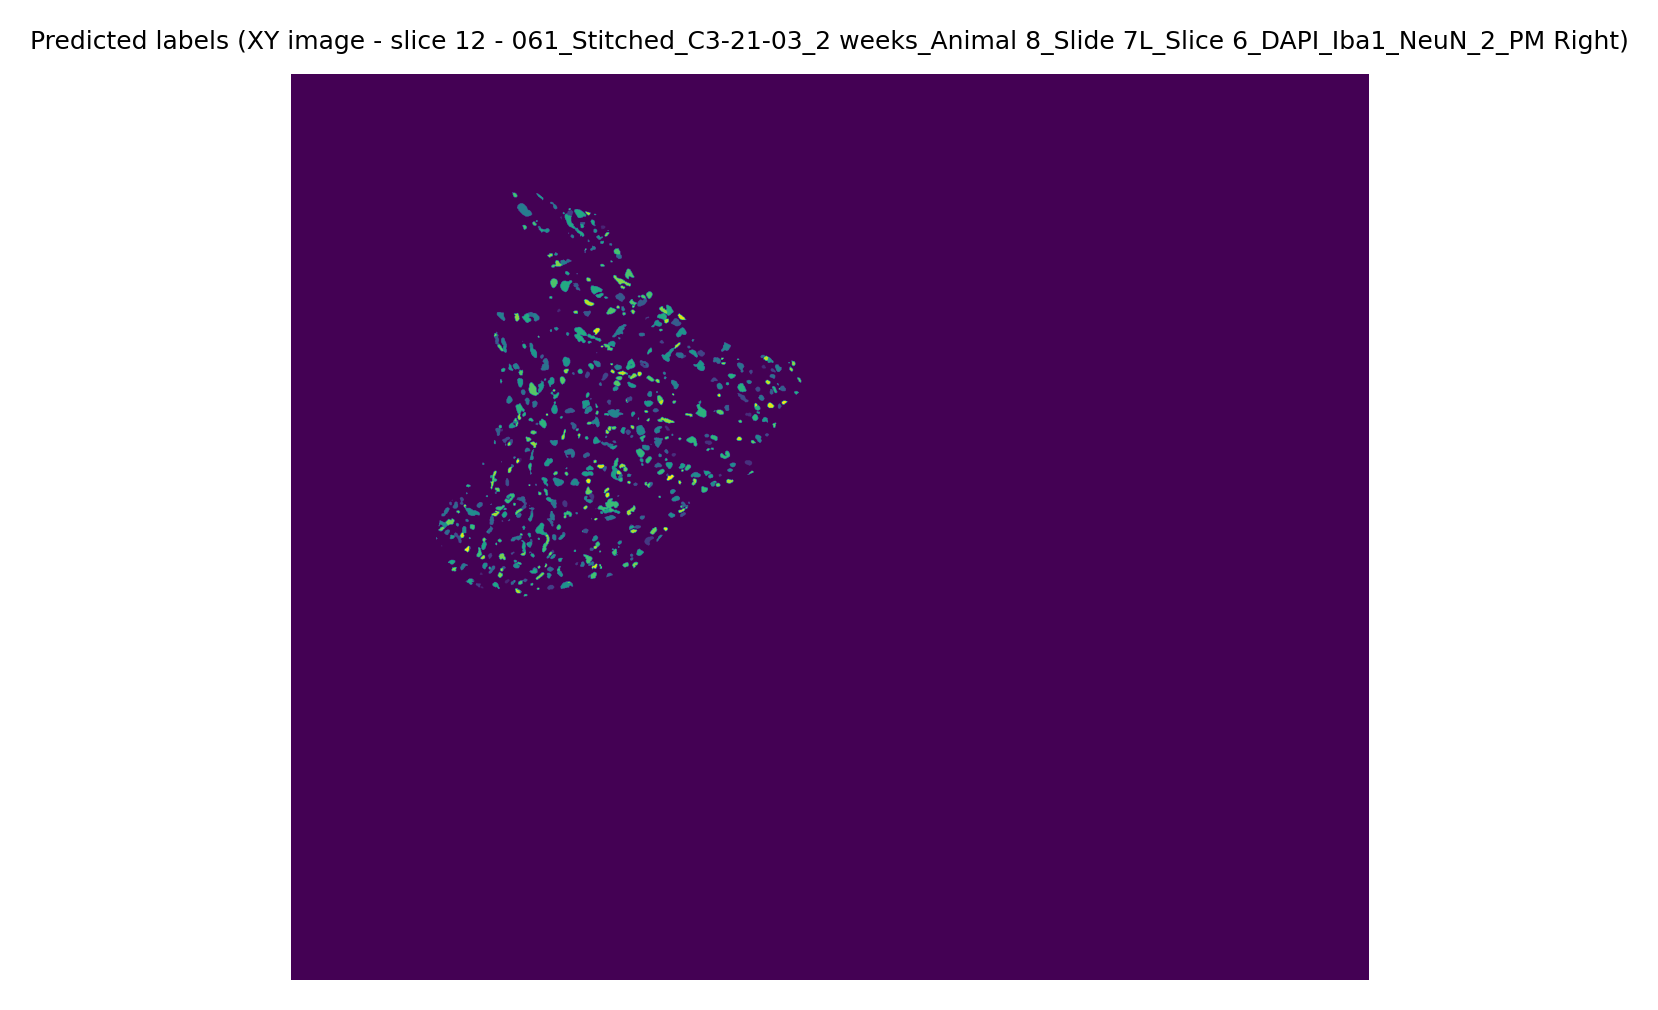

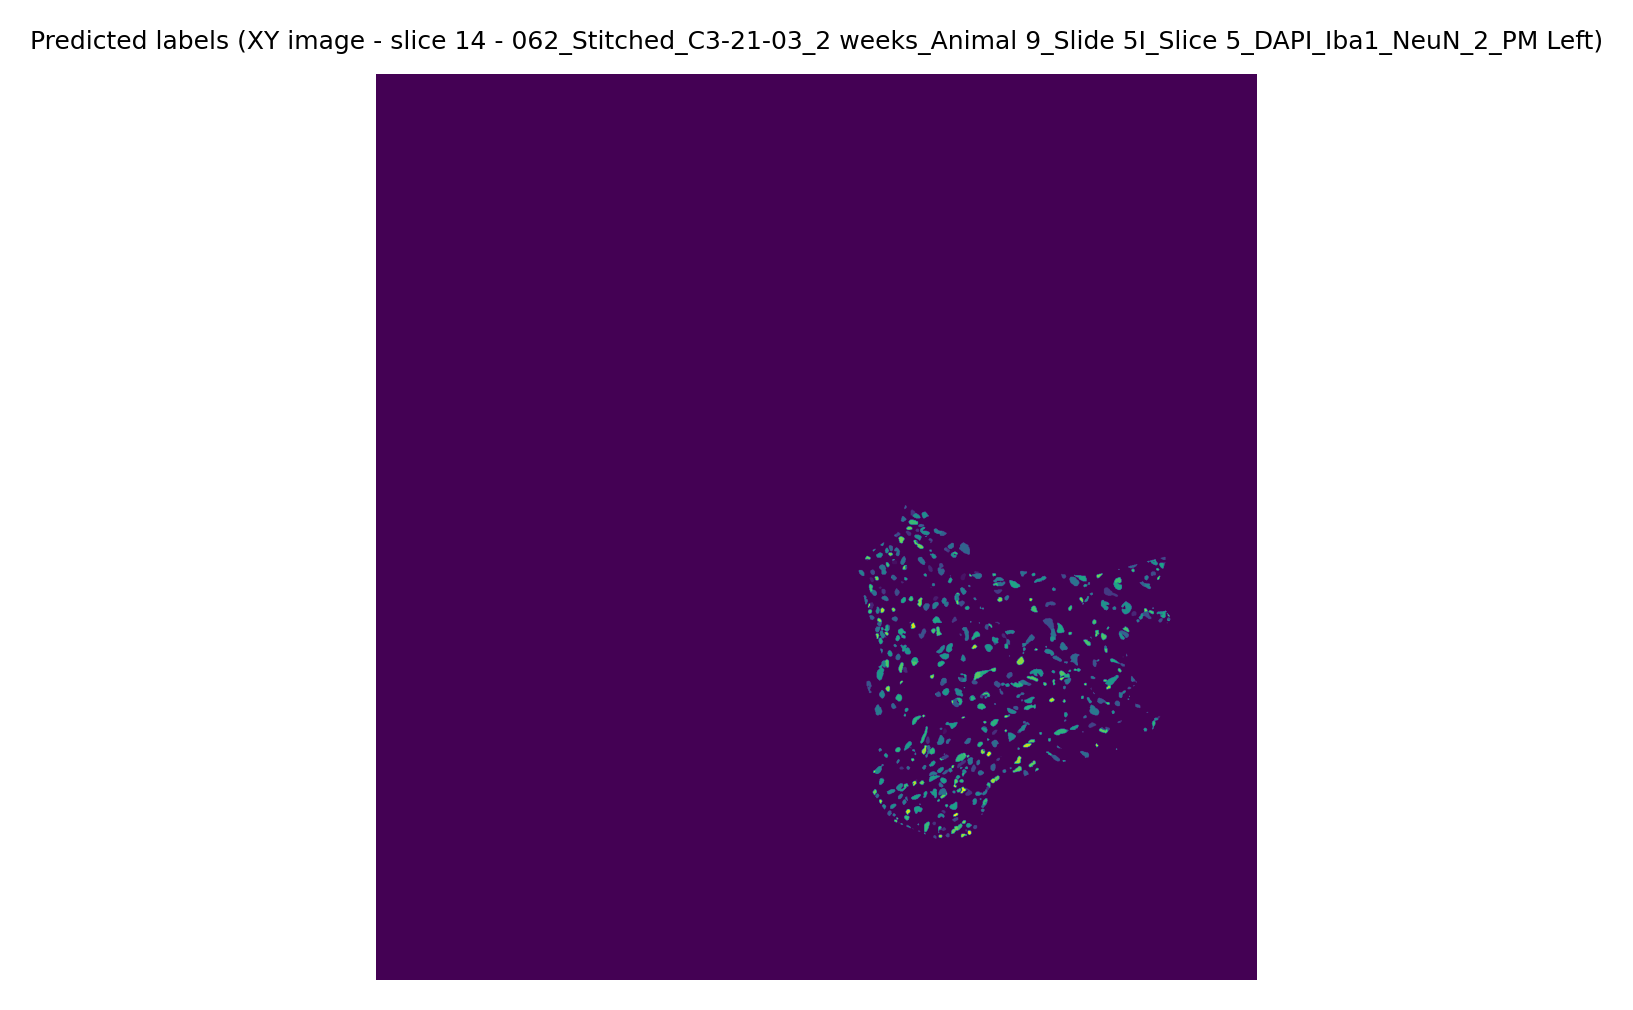

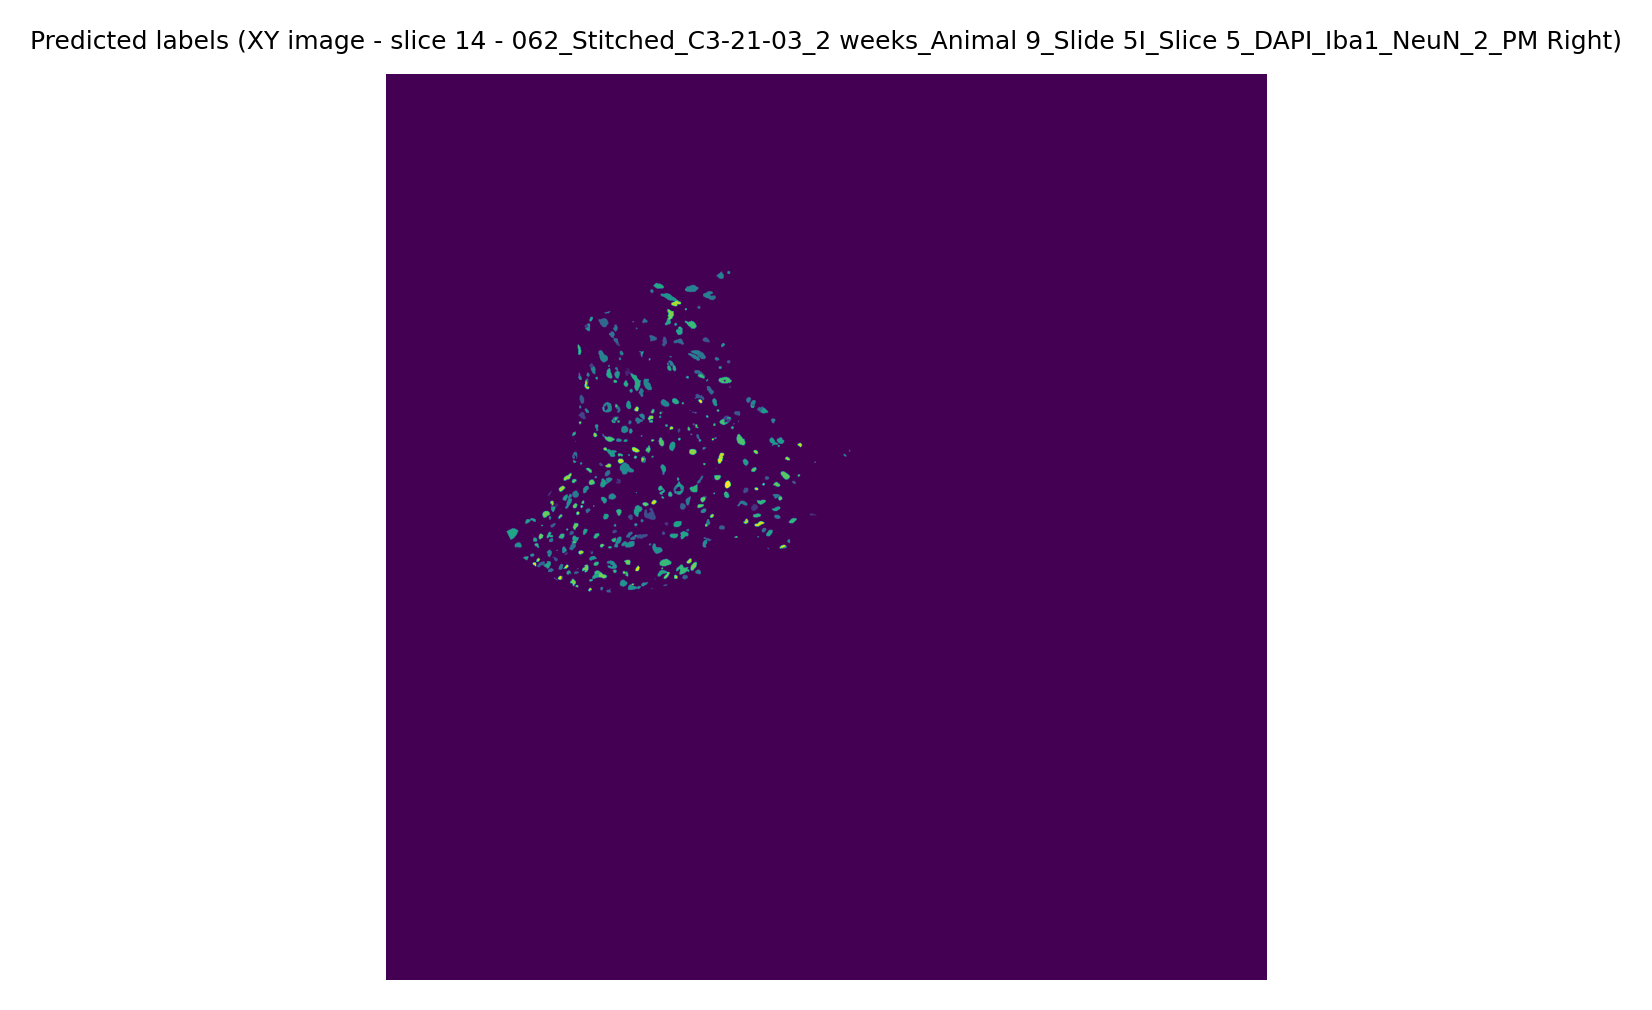

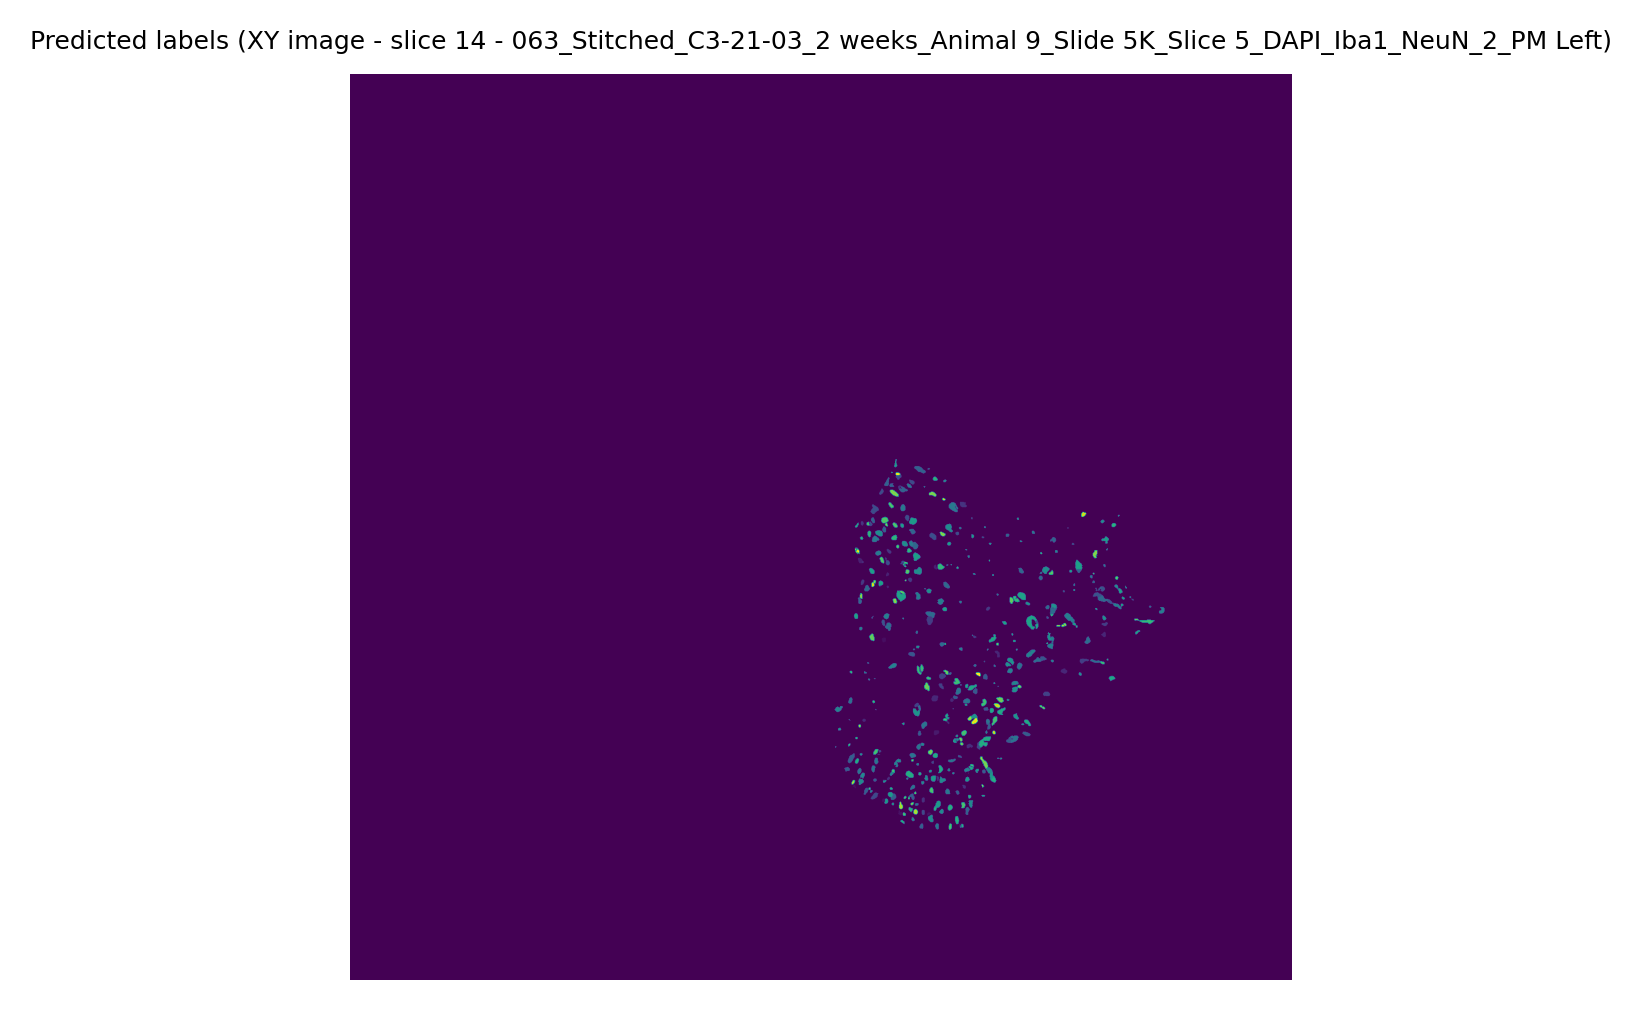

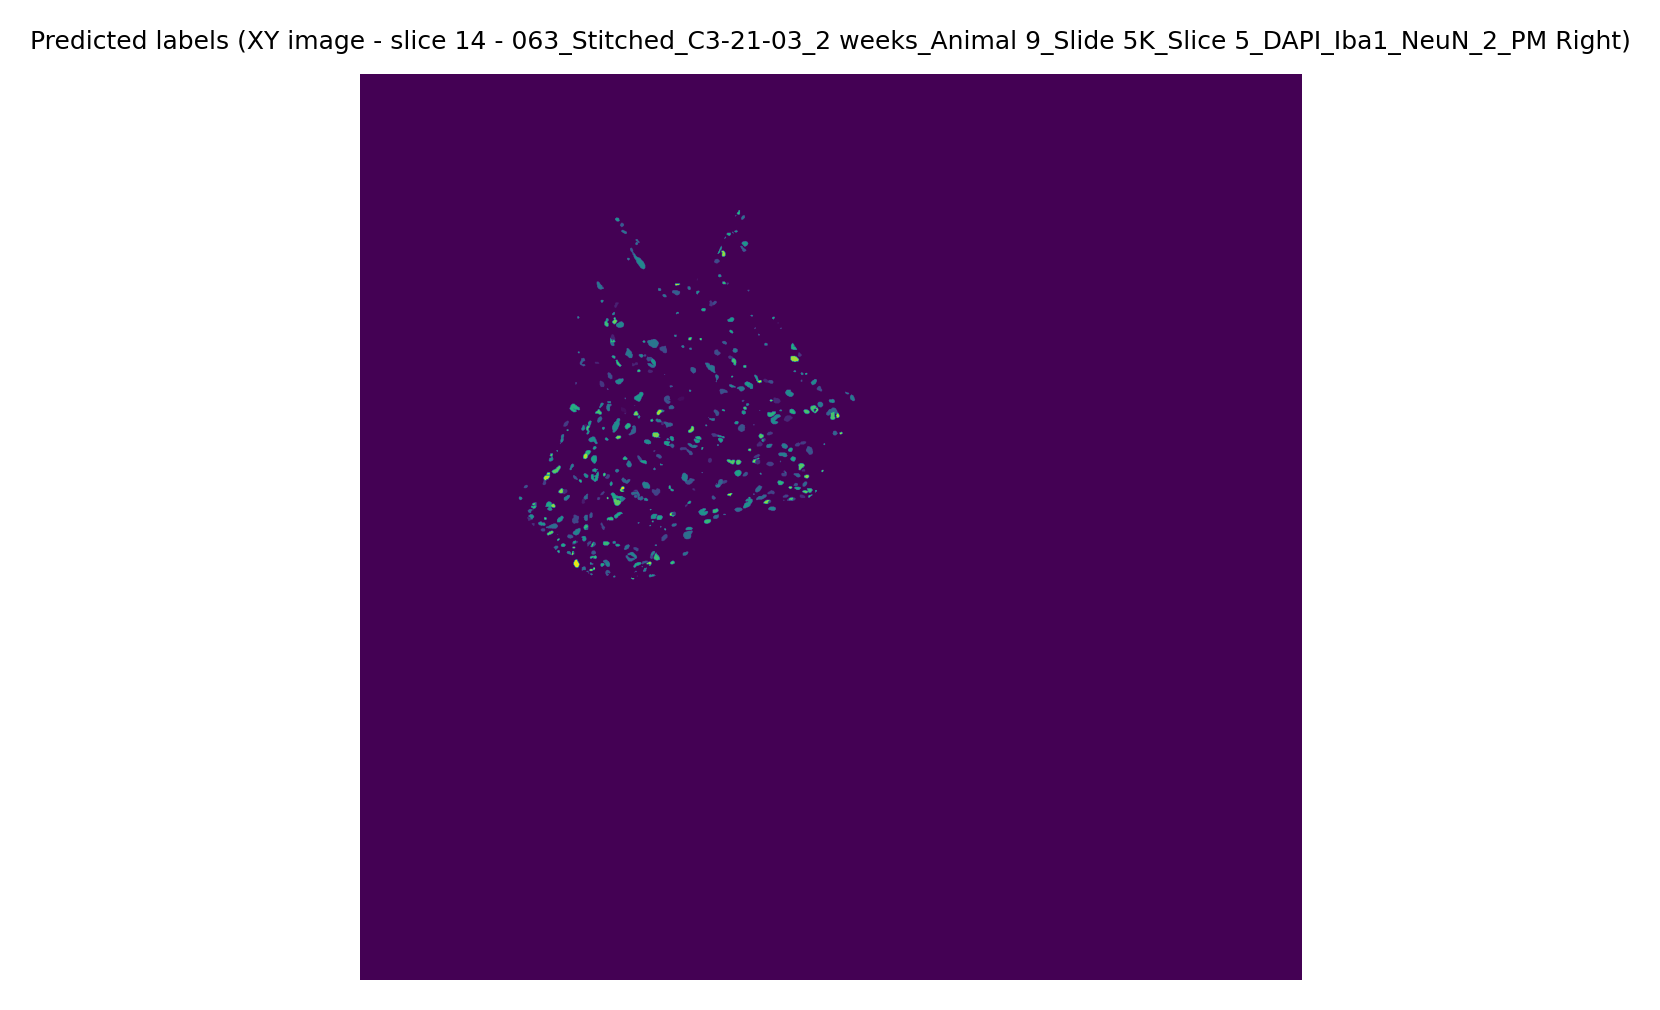

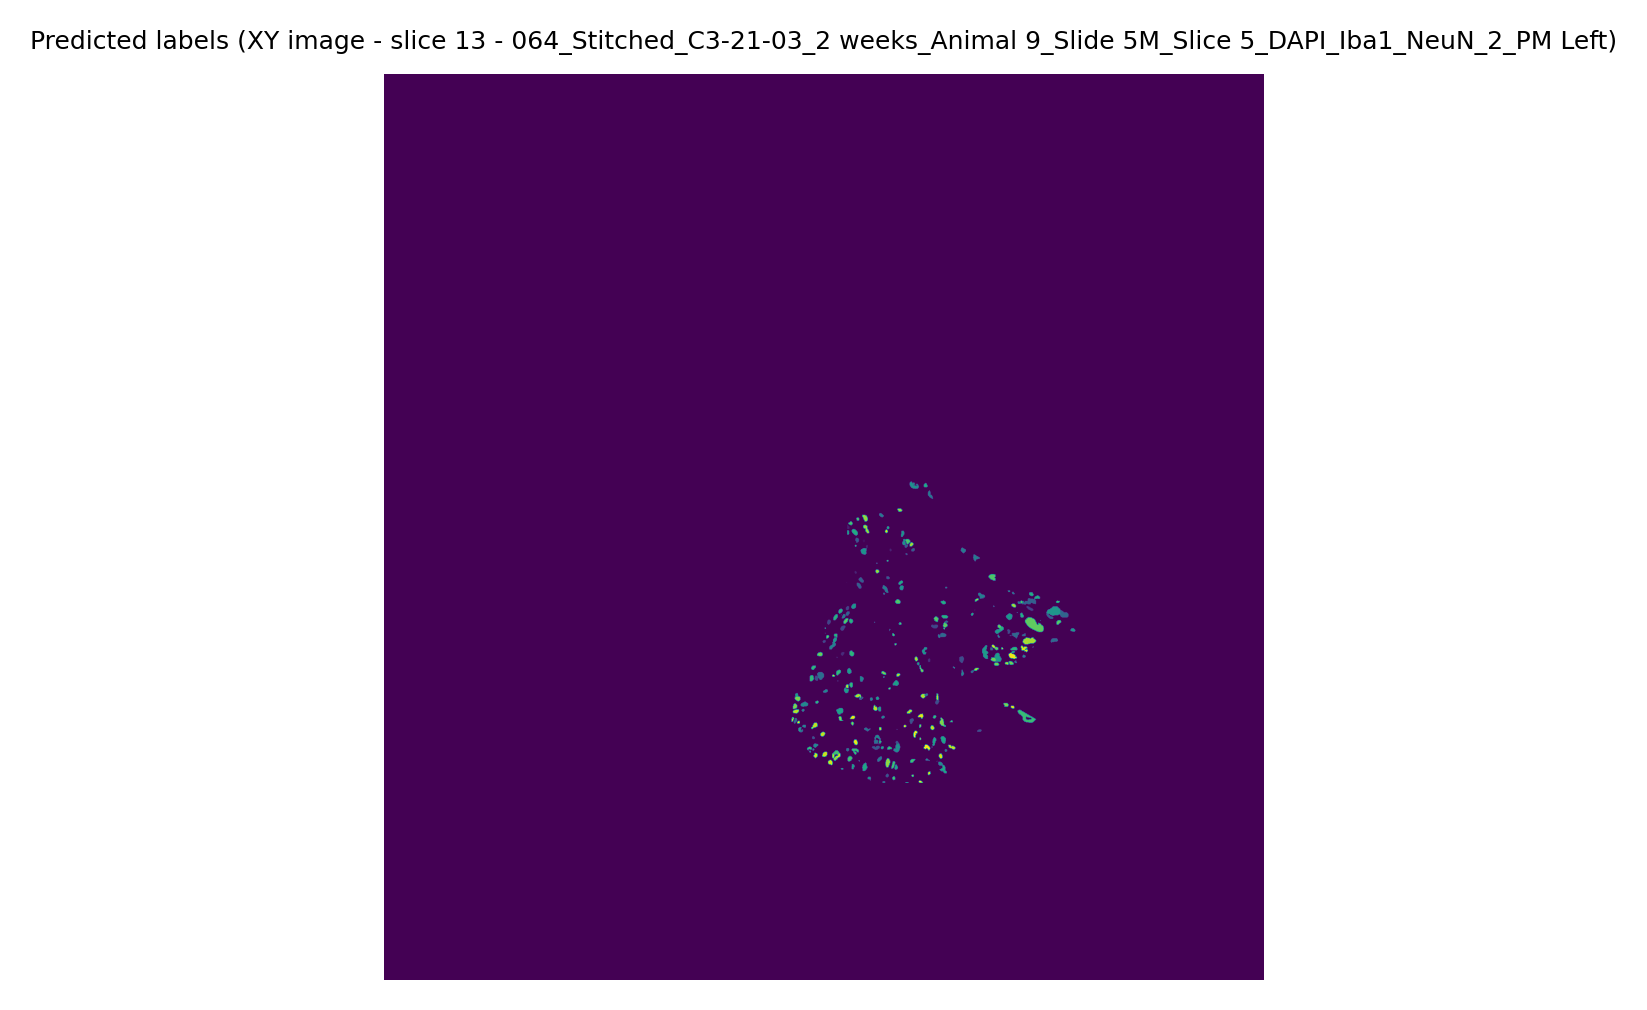

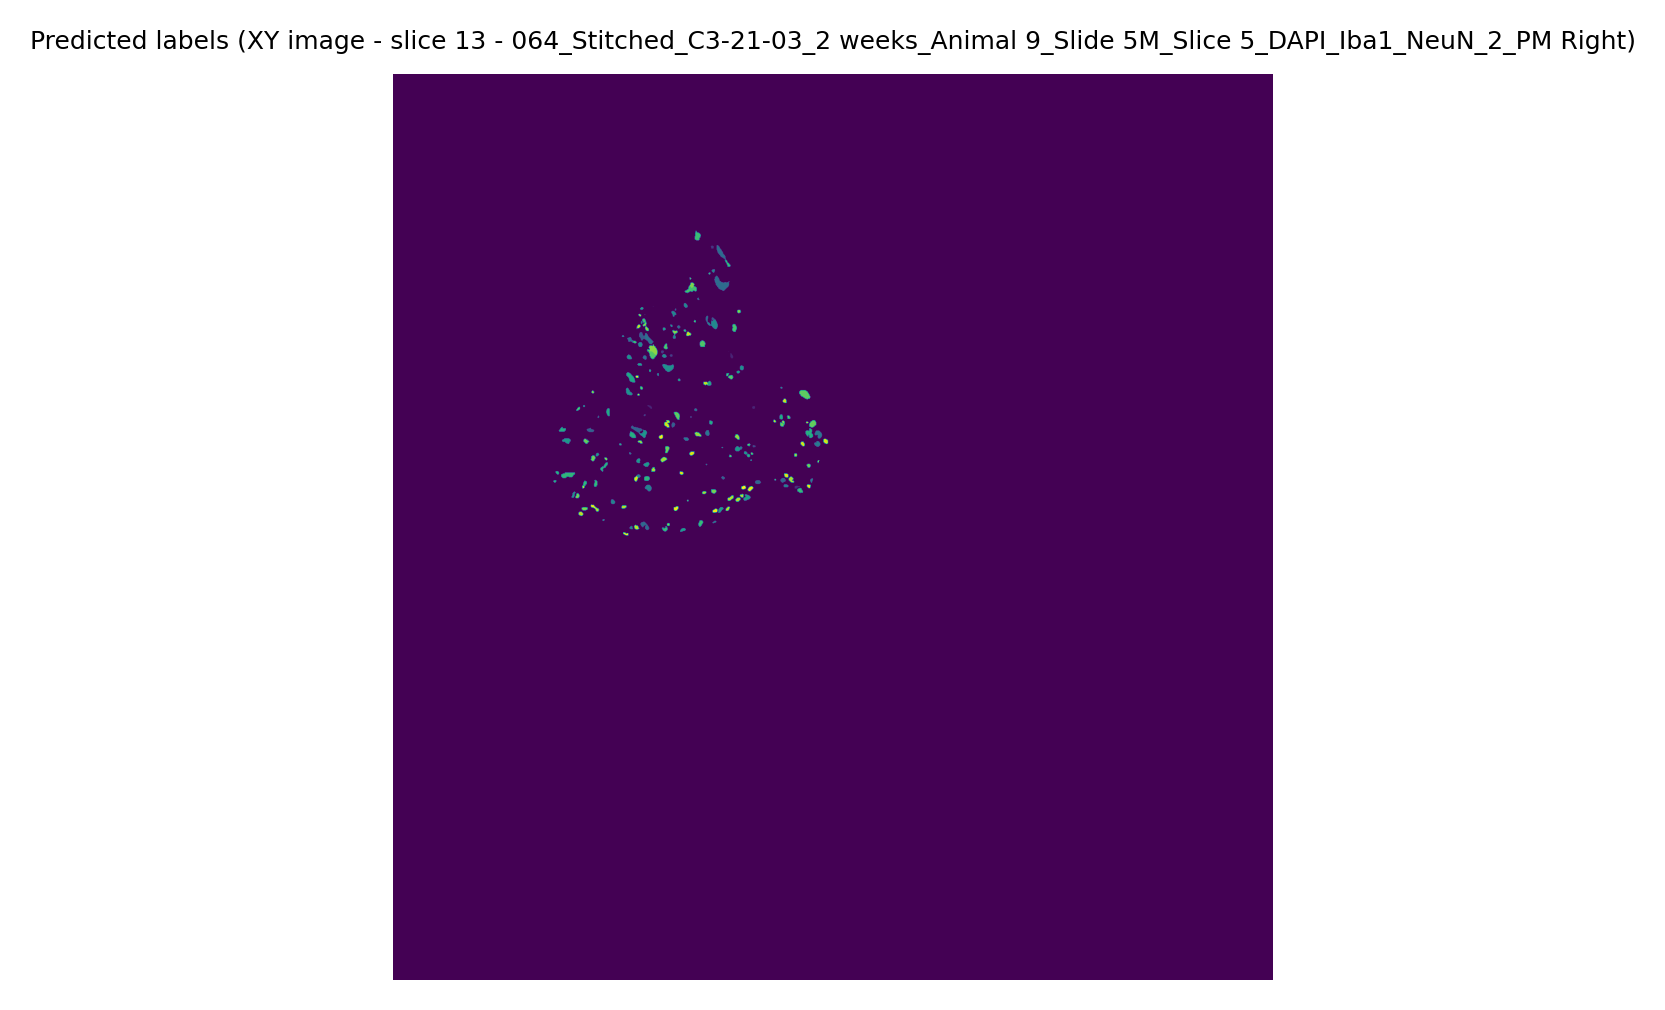

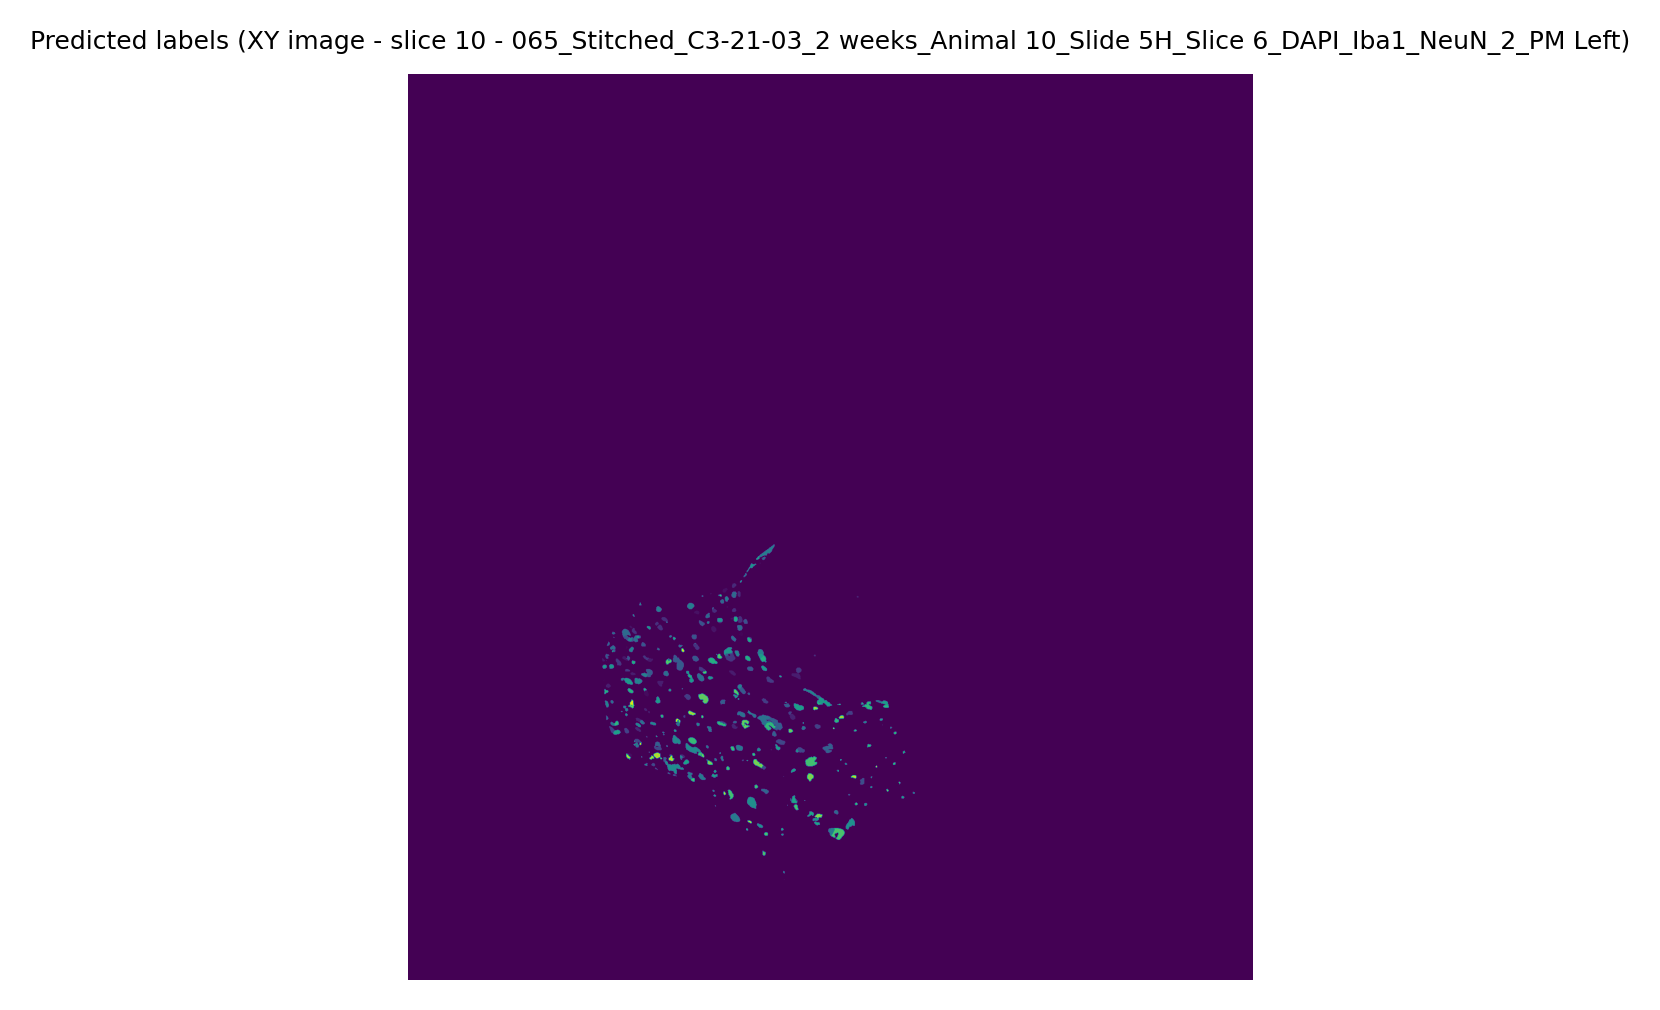

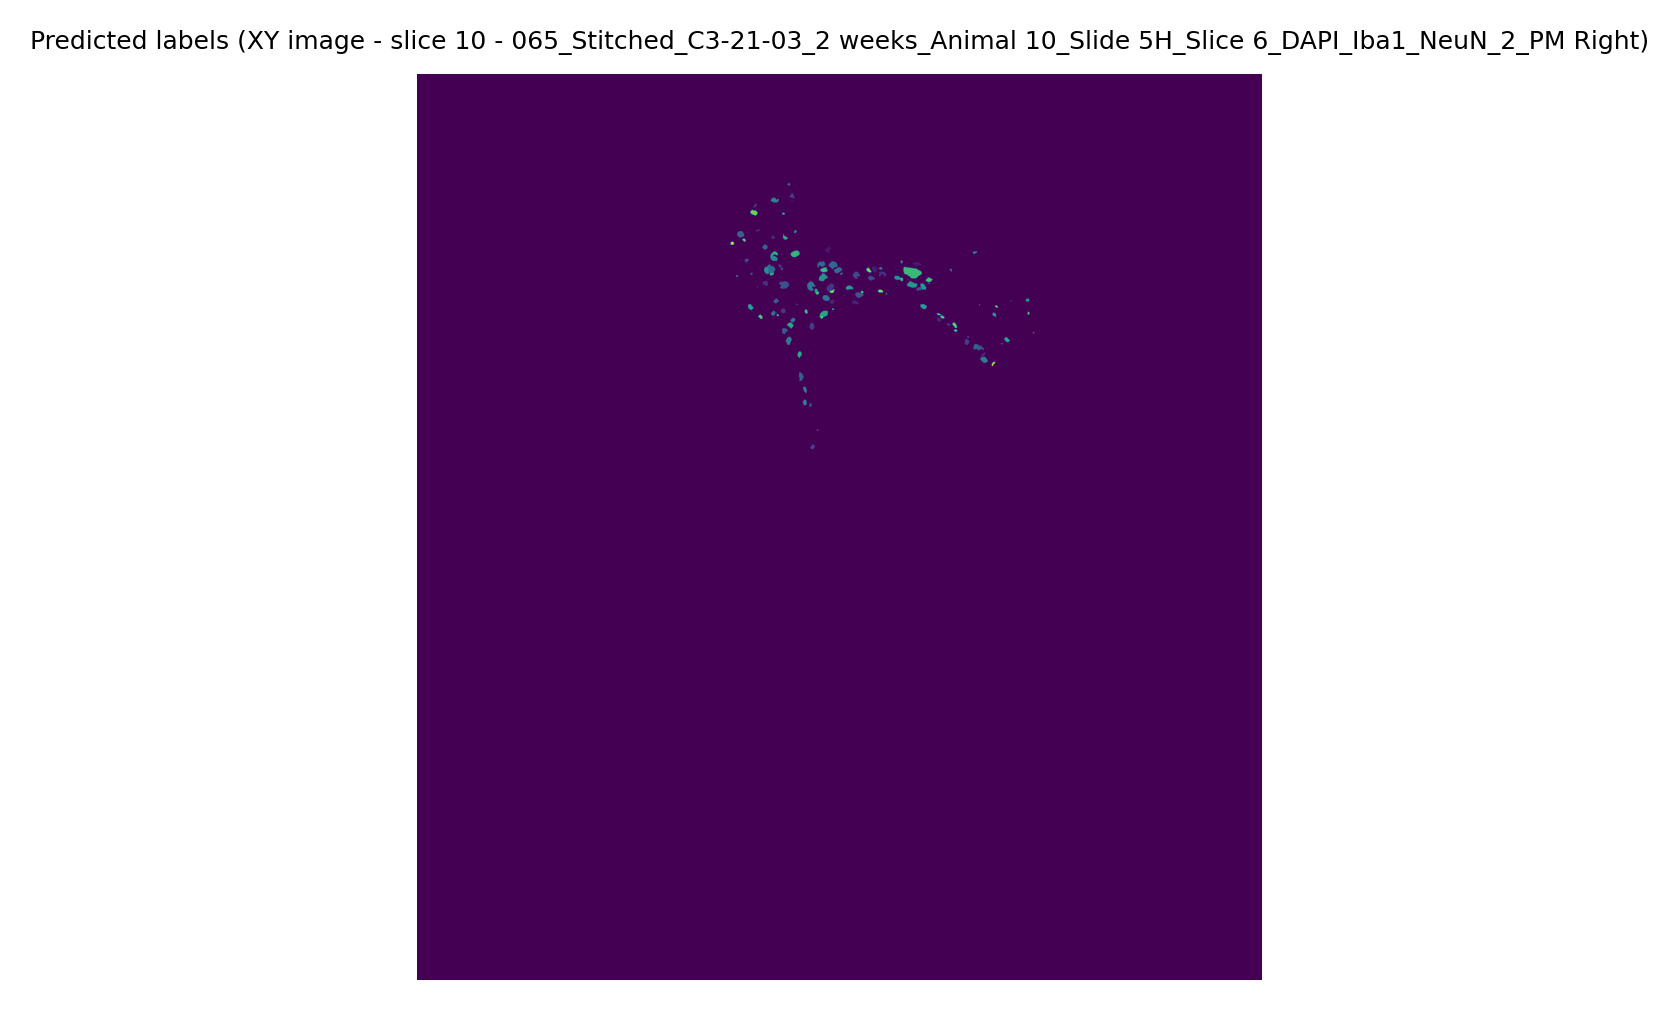

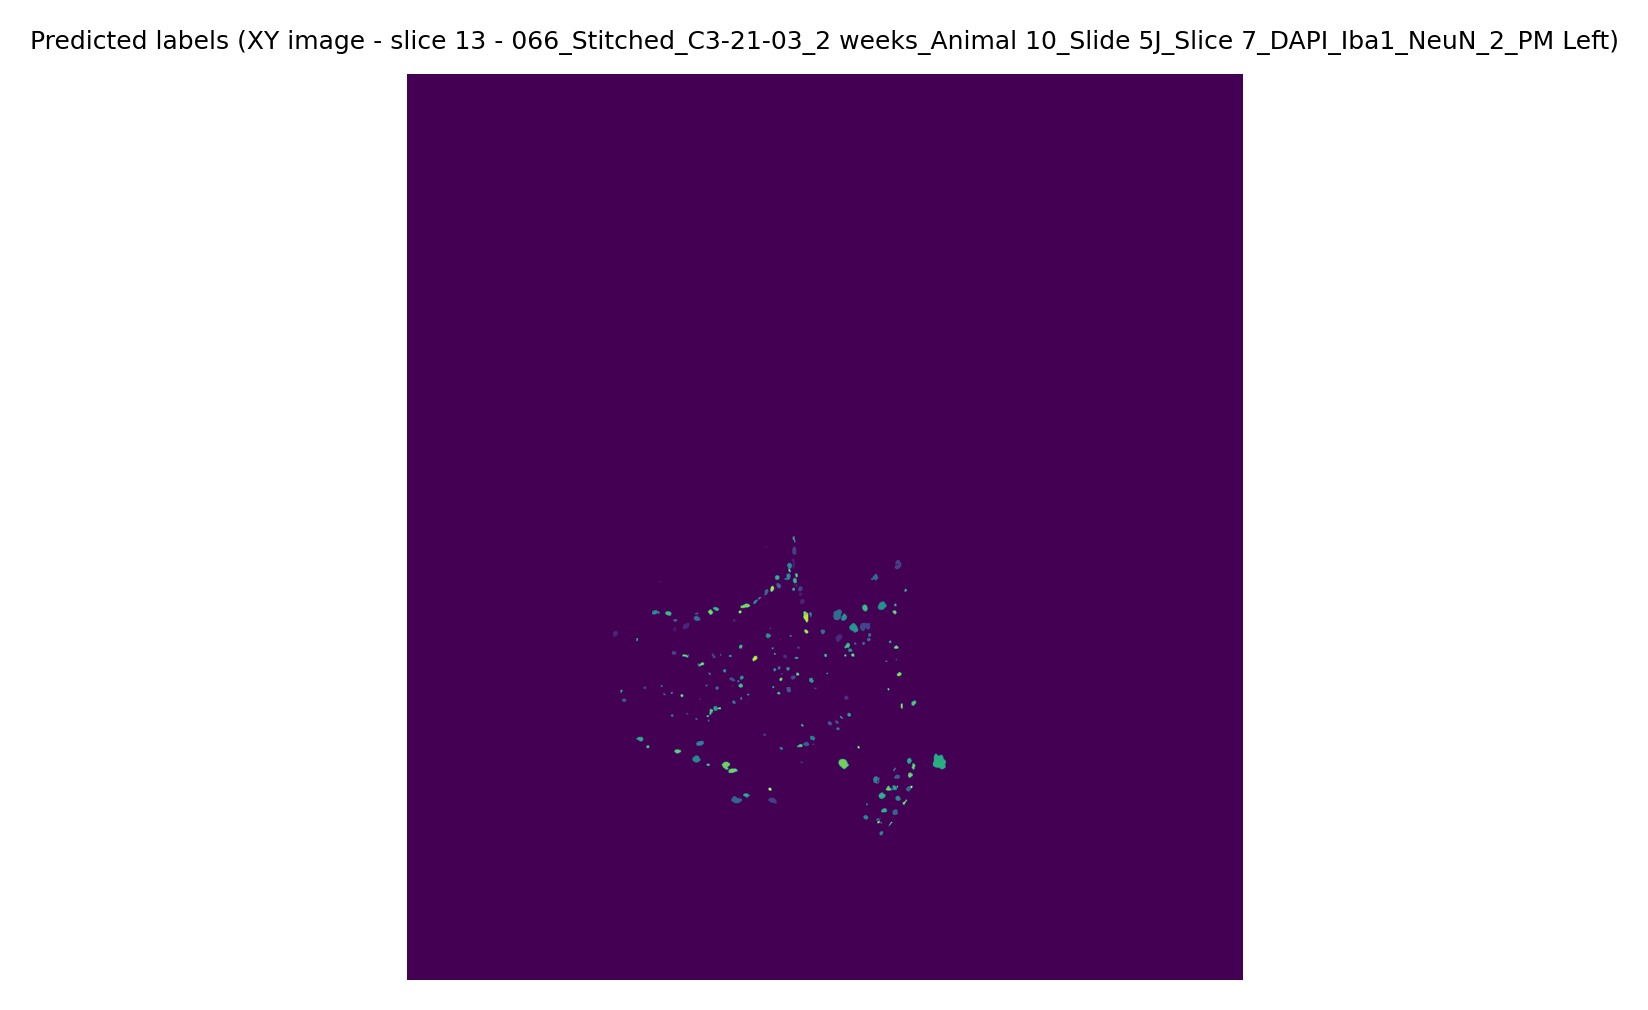

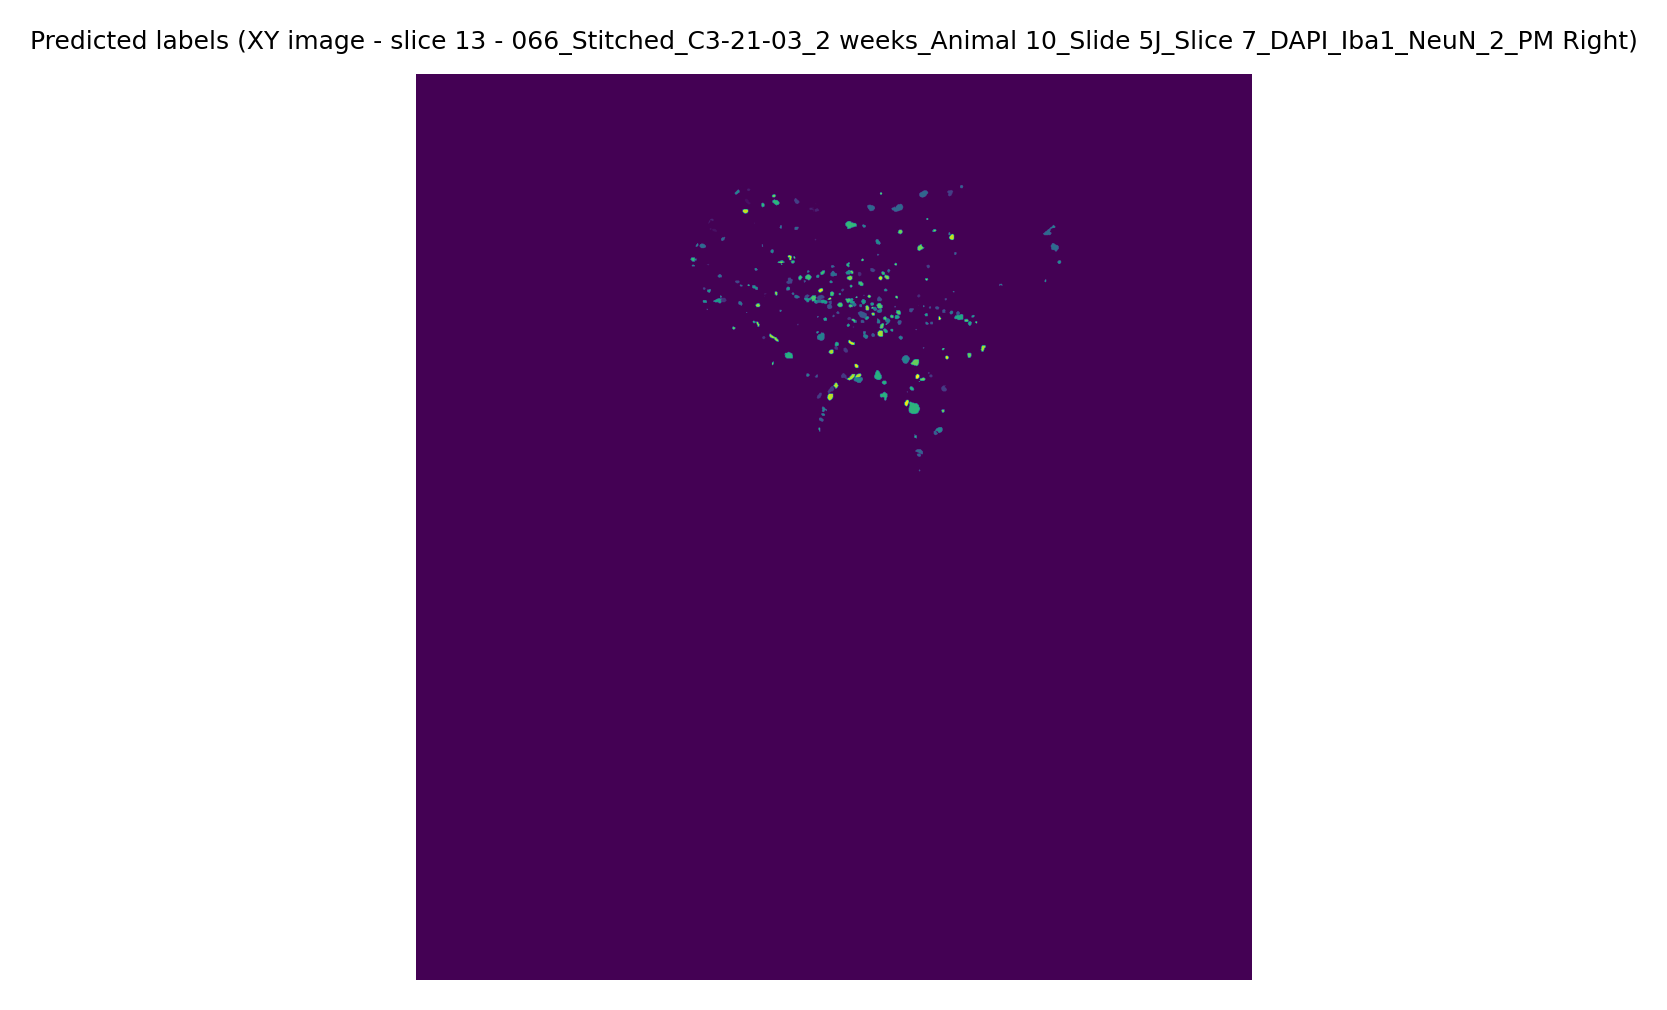

In [10]:
# Save the label stacks in the output result directory
# Masks images are 64 bits (masks[0].dtype). ImageJ support up to 32 bits!
for f in range(len(imgs)):  
    # Get file name and split the file name and the ext
    zSlices = masks[f].shape[0]
    output_name = os.path.basename(file_name[f])
    output_name = os.path.splitext(output_name)
    
    # Save results as tif (png works only for 2D)
    # The output is a 16 bits labeled image stack. The max number of objects is ~ 65000    
    if (large_objs_number == False):
        io.save_masks([], masks[f], [], os.path.join(output_path, output_name[0]), png=False, tif=True)
    else:
        save_name = os.path.join(output_path, output_name[0] + '_label_0' + str(f))
        imwrite(save_name + '.tiff', masks[f].astype(np.uint32), imagej=False)

    if display_intermendiated_results == True:
        plt.axis('off')
        plt.title('Predicted labels (XY image - slice ' + str(round(zSlices /2)) + ' - '+ output_name[0] + ')', fontsize=6)
        plt.imshow(masks[f][round(zSlices /2)])
        plt.show()  
    else:
        print('Processed:', os.path.join(output_path, output_name[0]))